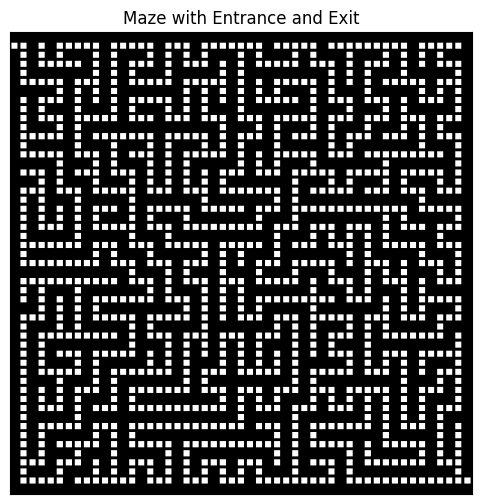

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import ListedColormap

def create_maze(dim):
    # Create a grid filled with walls (1)
    # Set the seed to ensure reproducibility
    np.random.seed(2)
    maze = np.ones((dim * 2 + 1, dim * 2 + 1), dtype=int)

    # Define the starting point
    x, y = (0, 0)
    maze[2 * x + 1, 2 * y + 1] = 0  # Mark start as open path

    # Initialize the stack with the starting point for DFS
    stack = [(x, y)]
    
    while stack:
        x, y = stack[-1]

        # Define possible directions (right, down, left, up)
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)  # Randomize order for more organic mazes

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            # Check if next cell is within bounds and is a wall
            if 0 <= nx < dim and 0 <= ny < dim and maze[2 * nx + 1, 2 * ny + 1] == 1:
                # Break wall to create path
                maze[2 * nx + 1, 2 * ny + 1] = 0
                maze[2 * x + 1 + dx, 2 * y + 1 + dy] = 0
                stack.append((nx, ny))  # Move to the next cell
                break
        else:
            stack.pop()  # Backtrack if no unvisited neighbors

    # Create entrance and exit points
    maze[1, 0] = 0  # Entrance
    maze[-2, -1] = 0  # Exit

    return maze

def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'black'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()

# Define the dimension of the maze (adjustable)
dim = 25  # This can be any positive integer
maze = create_maze(dim)
display_maze(maze)

In [47]:
class SolutionDrawer:
    def draw(self, maze, start, solution, generacion):
        counterMatrix = np.zeros(maze.shape, dtype=int)
    
        x, y = start
        counterMatrix[x][y] += 1
      
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

        while (0 <= y + 1 < len(maze[0])) and maze[x][y + 1] == 0:
            y += 1    
            counterMatrix[x][y] += 1
    
        for move in solution:
            dx, dy = directions[move[0]]
            steps = move[1]
            

            while (0 <= x + dx < len(maze) and 0 <= y + dy < len(maze[0])) and maze[x + dx][y + dy] == 0 and steps > 0:
                x, y = x + dx, y + dy
                counterMatrix[x][y] += 1
                steps -= 1
                    
                
        plt.figure(figsize=(8, 8))
        plt.title(f"Frecuencia de Movimientos en el Laberinto (Generación {generacion})")
        plt.imshow(counterMatrix, cmap='hot',interpolation='nearest')
        plt.colorbar(label="Número de Visitas")
        plt.xlabel("Columnas")
        plt.ylabel("Filas")
        plt.grid(False)
        plt.show()
        

In [48]:
import random
import numpy as np

class GeneticMazeSolver:
    
    def generate_population(self, size, genome_length):
        return [[(random.randint(0, 3), random.randint(1, genome_length) ) for _ in range(genome_length)] for _ in range(size)]
    
    def reward(self, individual, maze, start, end):
        x, y = start
        visited_cells = set()
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  
        visited_cells.add((x, y))
        
        total_reward = 50000000
        while (0 <= y + 1 < len(maze[0])) and maze[x][y + 1] == 0:
            y += 1    
            visited_cells.add((x, y))
            total_reward += 100000
            
        for move in individual:
            dx, dy = directions[move[0]]
            steps = move[1]
            
            if not ((0 <= x + dx < len(maze) and 0 <= y + dy < len(maze[0])) and maze[x + dx][y + dy] == 0):
                total_reward -= 1000
                continue

            while (0 <= x + dx < len(maze) and 0 <= y + dy < len(maze[0])) and maze[x + dx][y + dy] == 0 and steps > 0:
                x, y = x + dx, y + dy
                steps -= 1
                if (x, y) not in visited_cells:
                    visited_cells.add((x, y))
                    total_reward += 100000
                    
                else:
                    total_reward -= 100
            if steps:
                total_reward -= 10*steps


            if (x, y) == end:
                total_reward += 50000000000
                break
        total_reward -= ((x - end[0])**2 + (y - end[1])**2)**0.5
        return total_reward
    
    def crossover(self, parent1, parent2):
        pivot = random.randint(0, len(parent1) - 1)
        child1 = parent1[:pivot] + parent2[pivot:]
        child2 = parent2[:pivot] + parent1[pivot:]
        return child1, child2
    
    def mutate(self, individual, mutation_rate):
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                individual[i] = (random.randint(0, 3), max(1,individual[i][1] + random.randint(-5, 5)))
                
    def select(self, population, fitnesses):
        totalFitness = sum(fitnesses)
        padres = []
        for _ in range(2):
            ruleta = random.uniform(0, totalFitness)
            acumulado = 0
            for i in range(len(population)):
                acumulado += fitnesses[i]
                if acumulado > ruleta:
                    padres.append(population[i])
                    break
        return padres


    
    def evolve(self, population, maze, start, end):
        drawer = SolutionDrawer()
        generaciones = 100
        fitnesses = [self.reward(individual, maze, start, end) for individual in population]
        for i in range(generaciones):
            nuevaPoblacion = []
            for _ in range(len(population) - int(0.2 * len(population))):
                padre1, padre2 = self.select(population, fitnesses)
                if random.random() < 0.8:
                    hijo1, hijo2 = self.crossover(padre1, padre2)
                else:
                    hijo1, hijo2 = padre1, padre2
                nuevaPoblacion.extend([hijo1, hijo2])
                nuevaPoblacion.sort(key=lambda x: self.reward(x, maze, start, end), reverse=True)
                
                nuevaPoblacion = nuevaPoblacion[:len(population)]
                
            for individuo in nuevaPoblacion:
                self.mutate(individuo, 0.25)


            population.sort(key=lambda individuo: self.reward(individuo, maze, start, end), reverse=True)
            nuevaPoblacion.sort(key=lambda individuo: self.reward(individuo, maze, start, end), reverse=True)
           
            populationSize = len(population)
            population =  population[:int(0.2 * len(population))] + nuevaPoblacion[:populationSize - int(0.2 * len(population))]
            fitnesses = [self.reward(individual, maze, start, end) for individual in population]
            mejorIndividuo = population[0]
            mejorFitness = self.reward(mejorIndividuo, maze, start, end)
            drawer.draw(maze, start, mejorIndividuo, i+1)

            
            
        return mejorIndividuo, mejorFitness

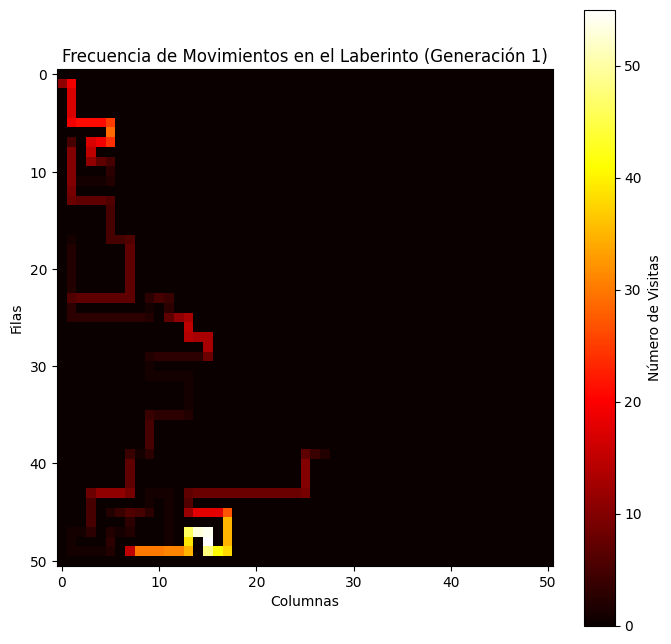

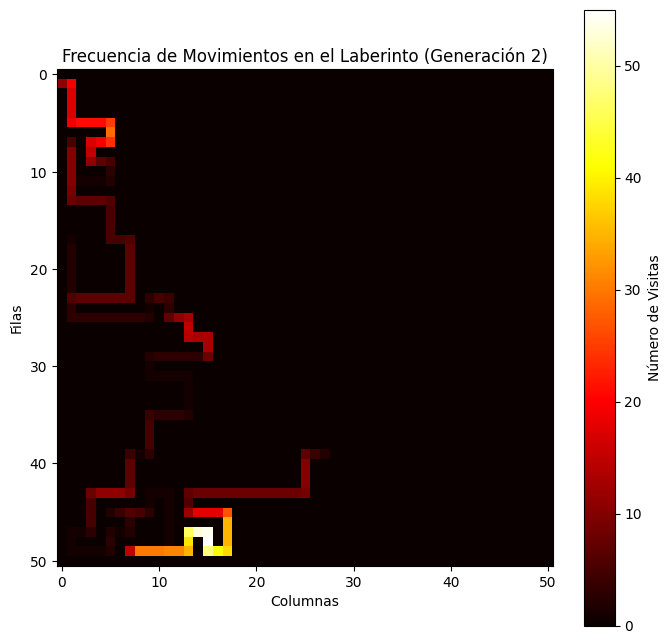

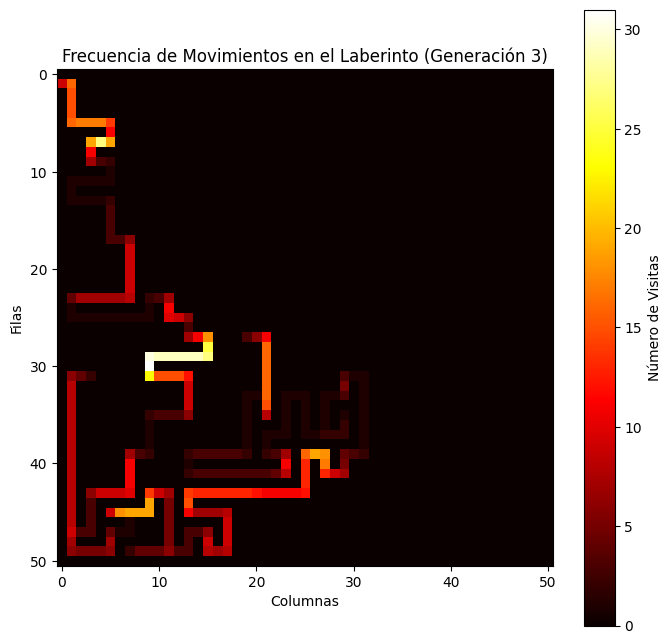

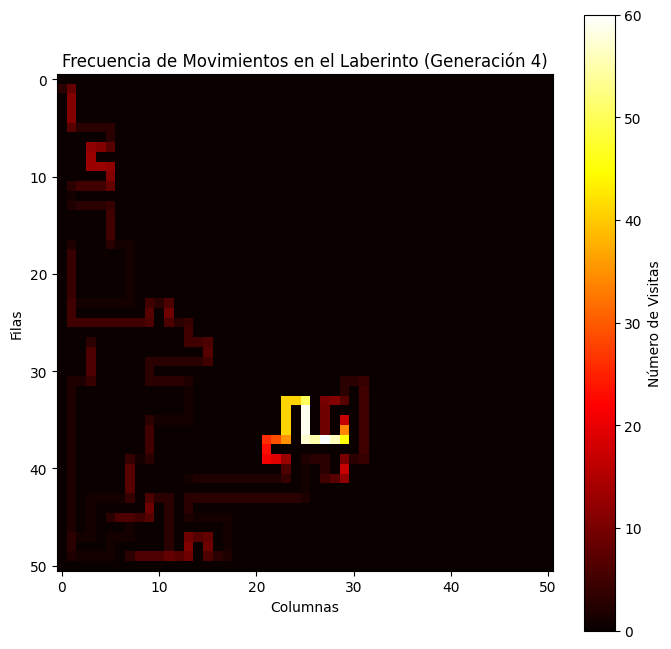

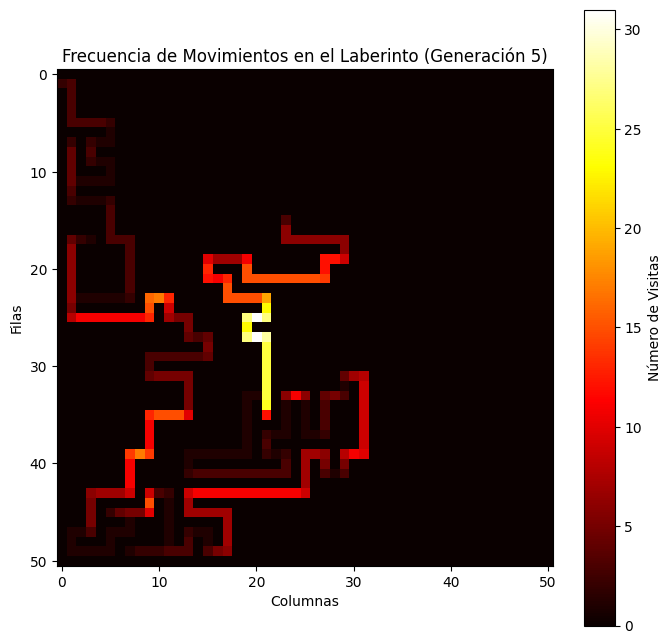

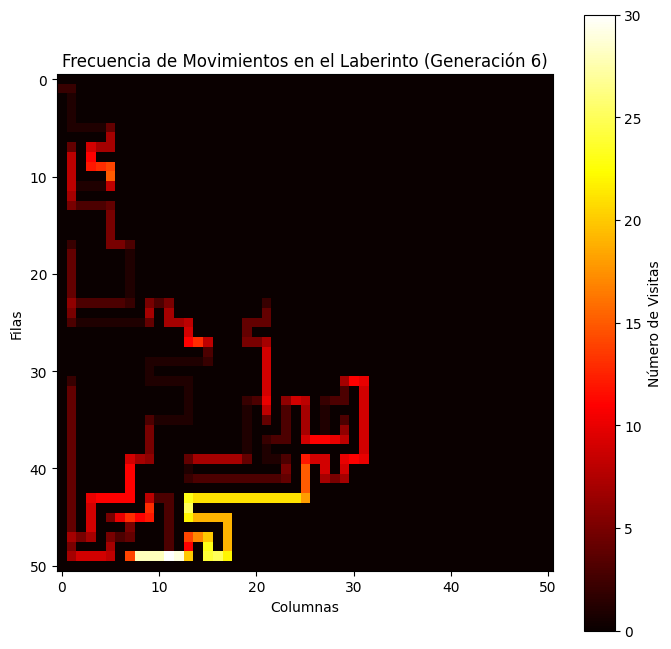

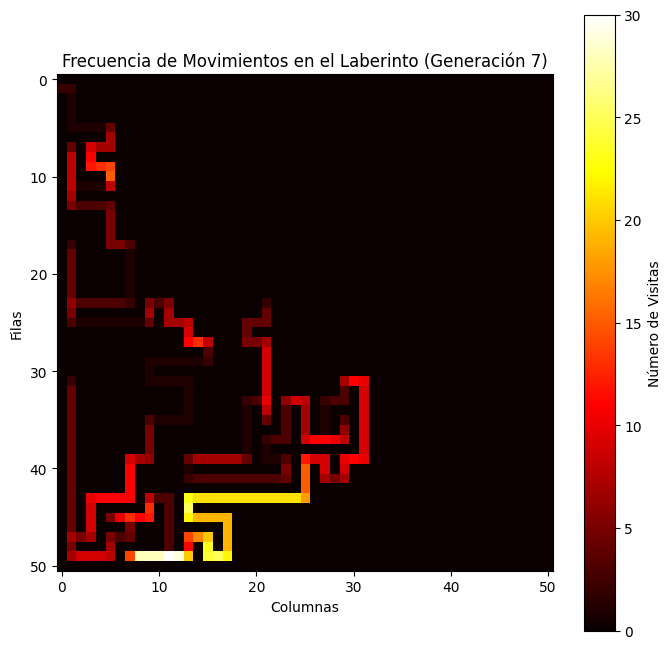

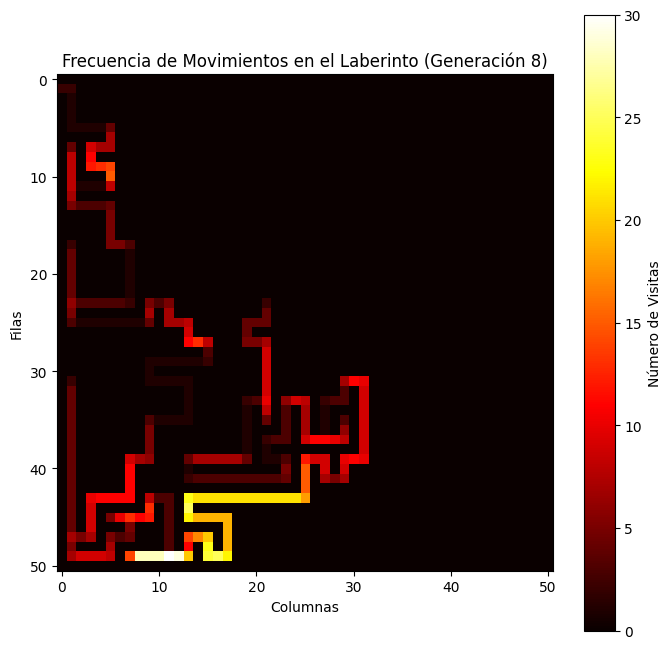

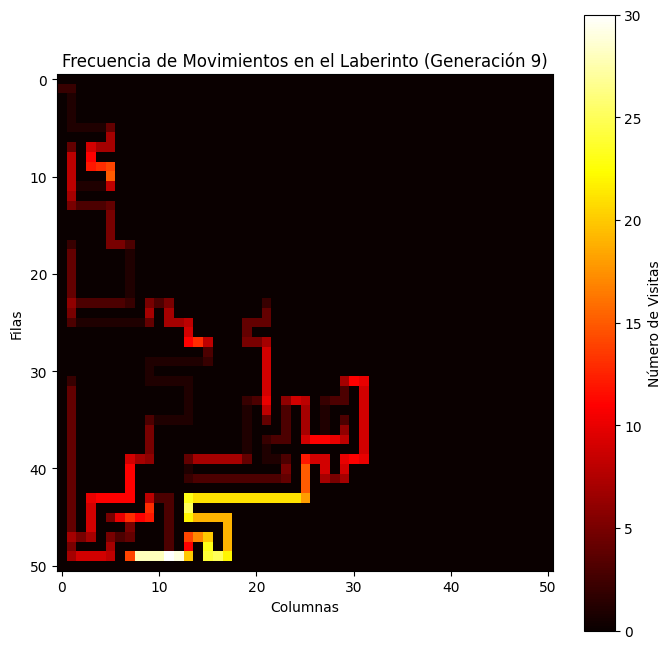

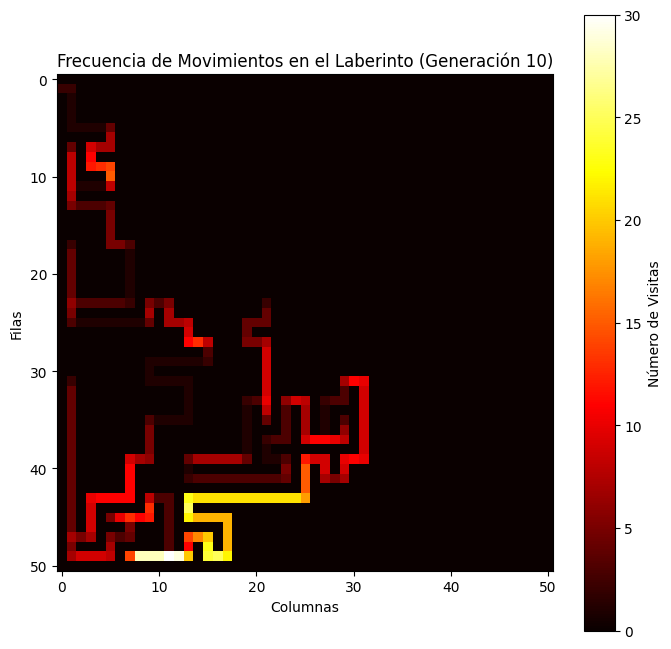

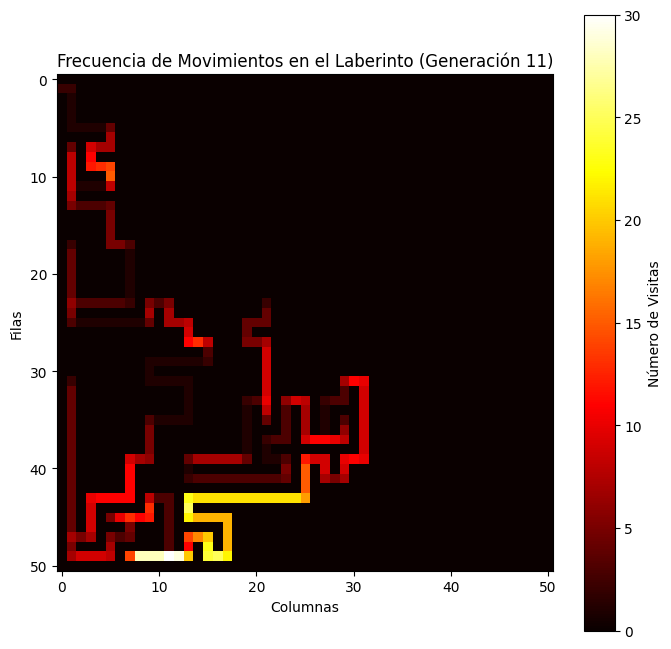

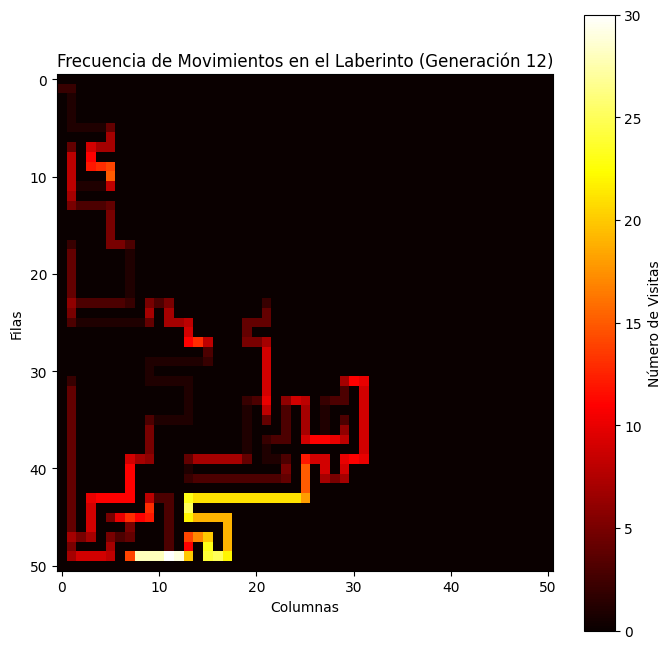

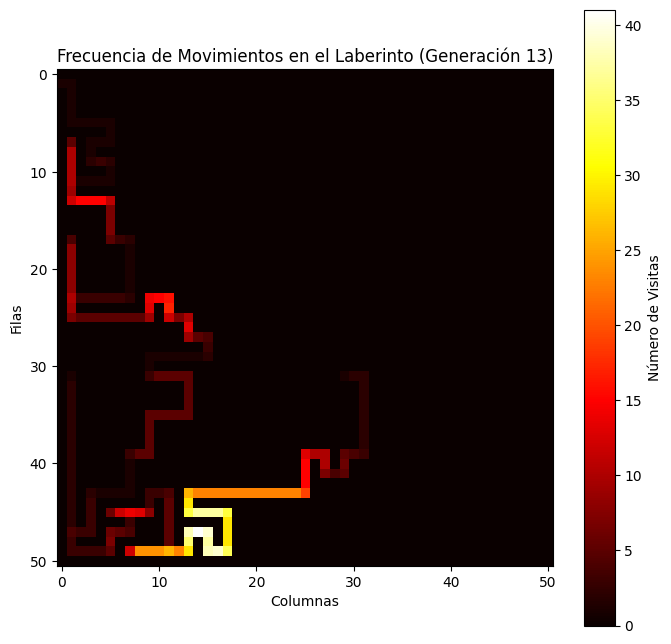

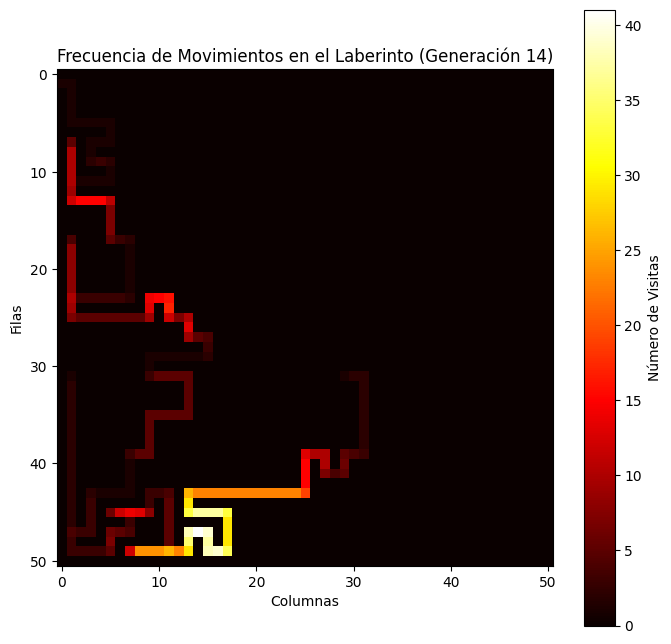

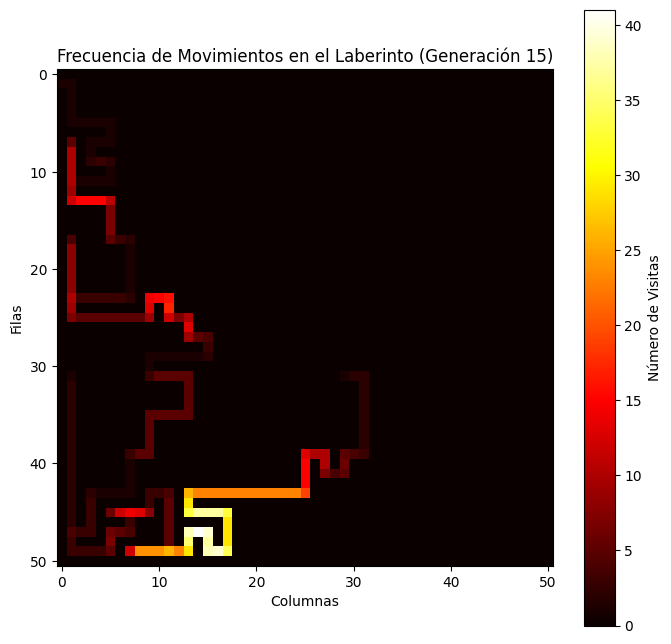

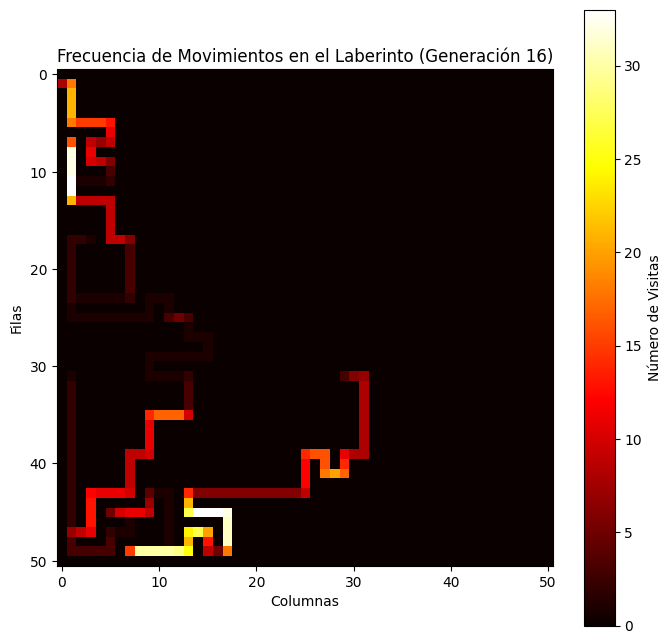

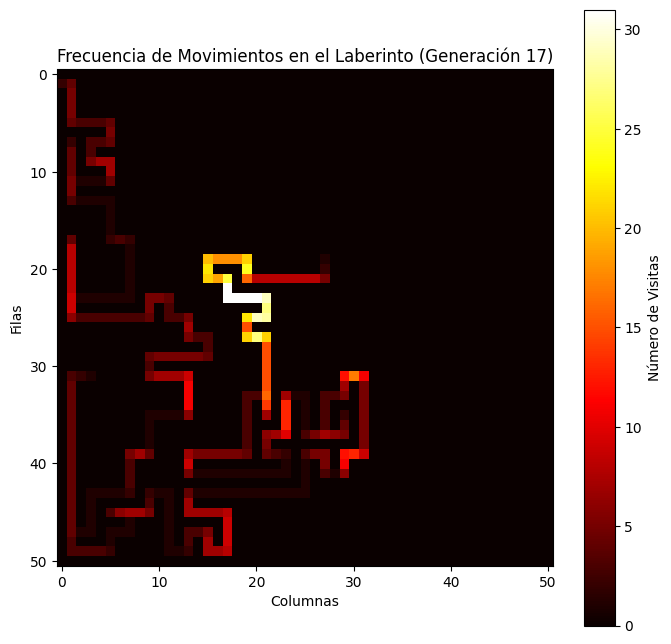

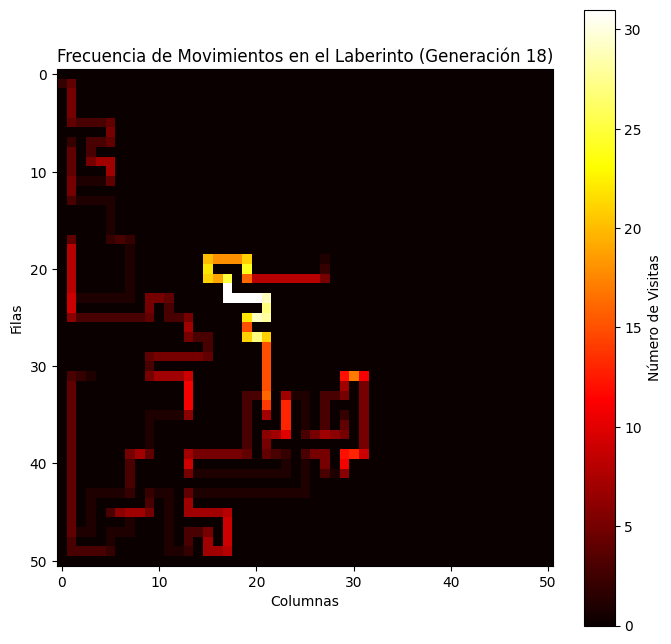

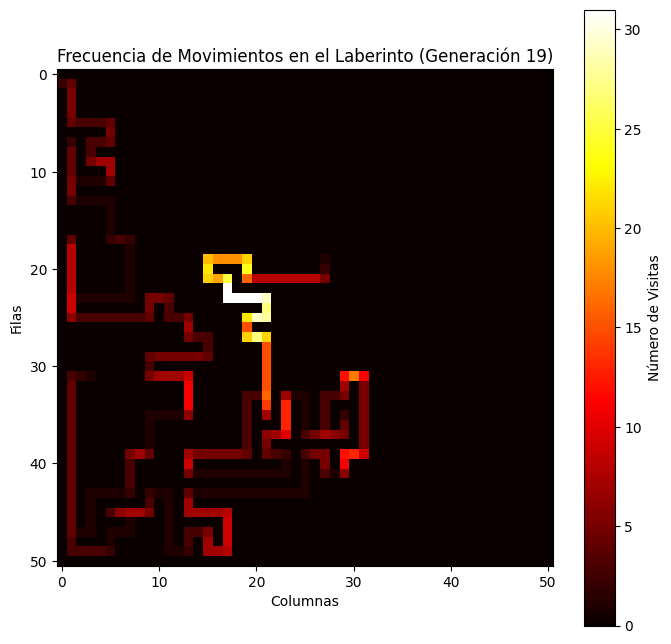

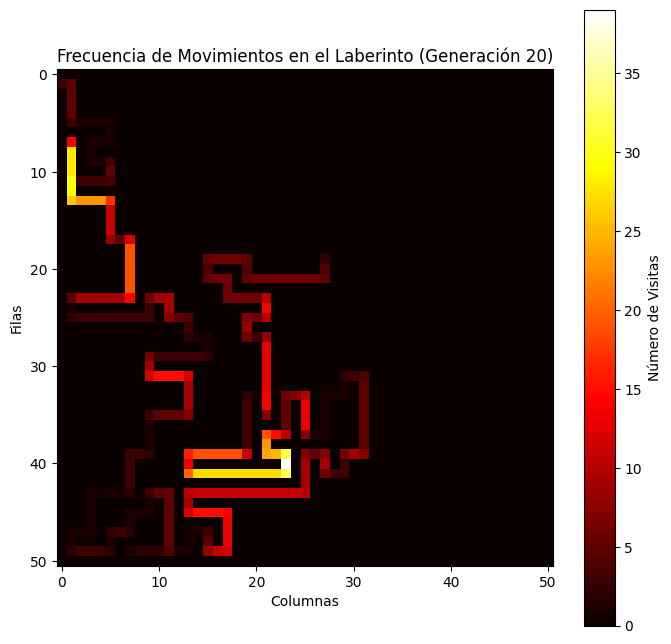

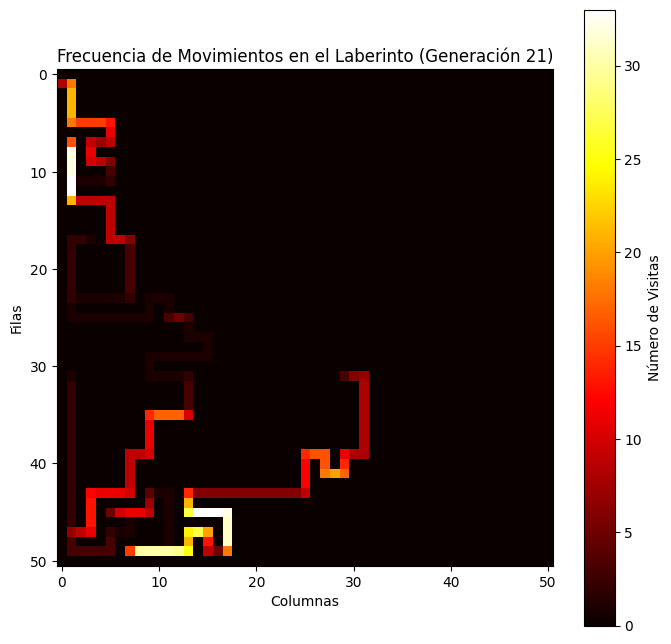

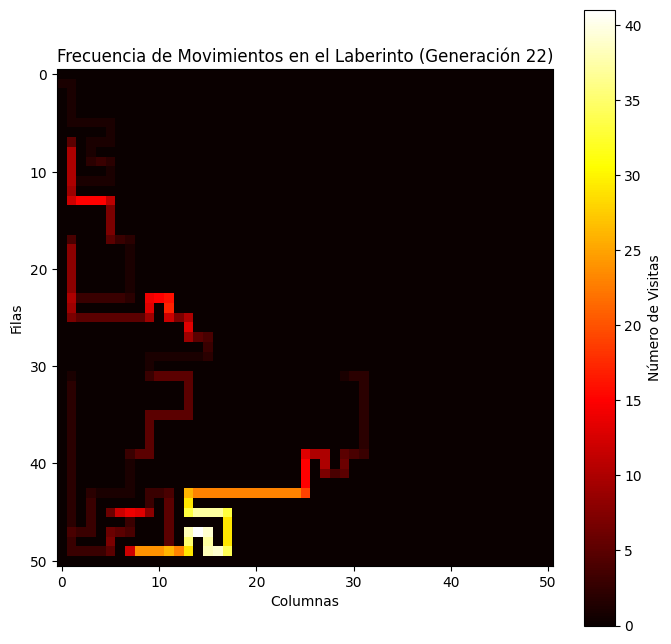

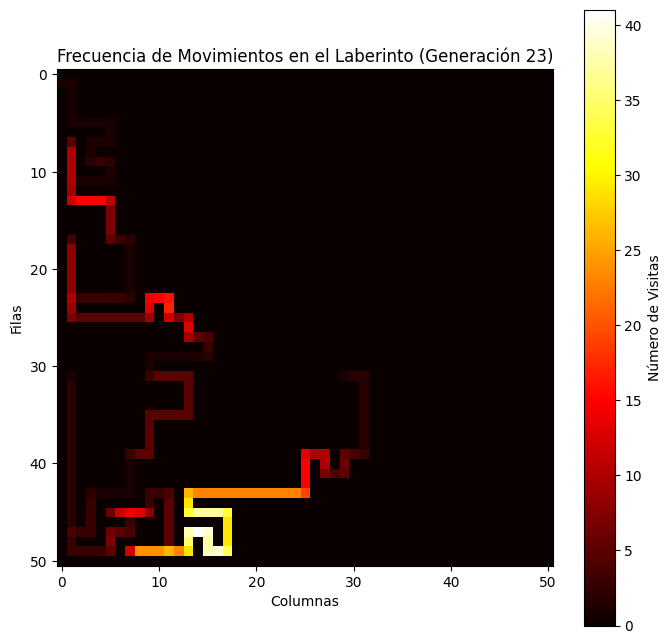

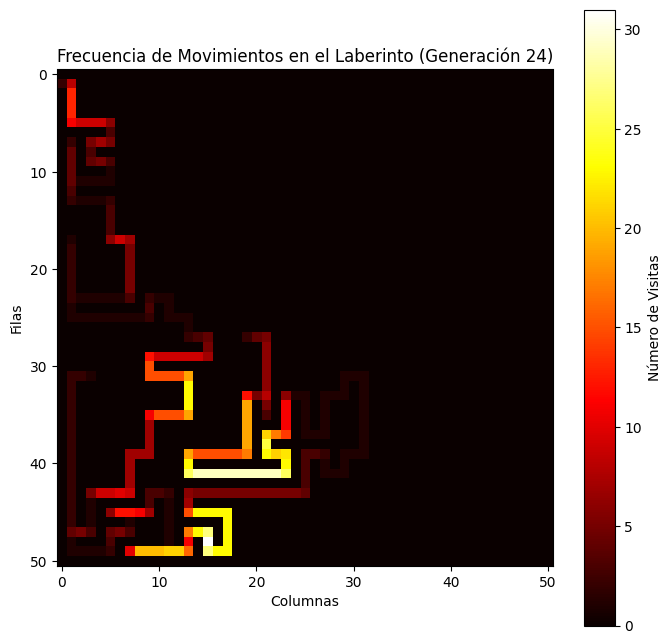

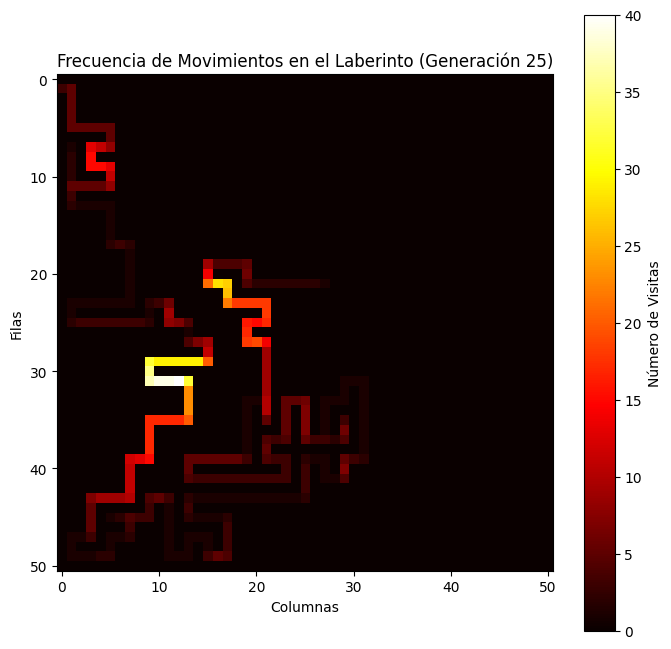

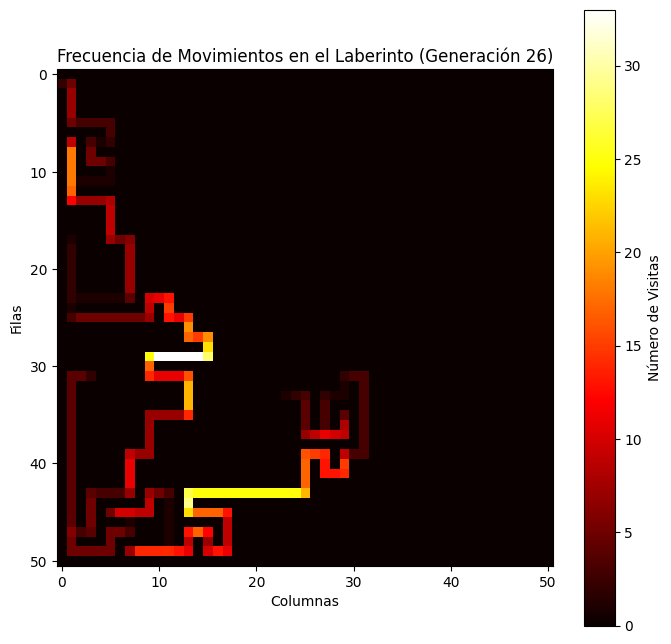

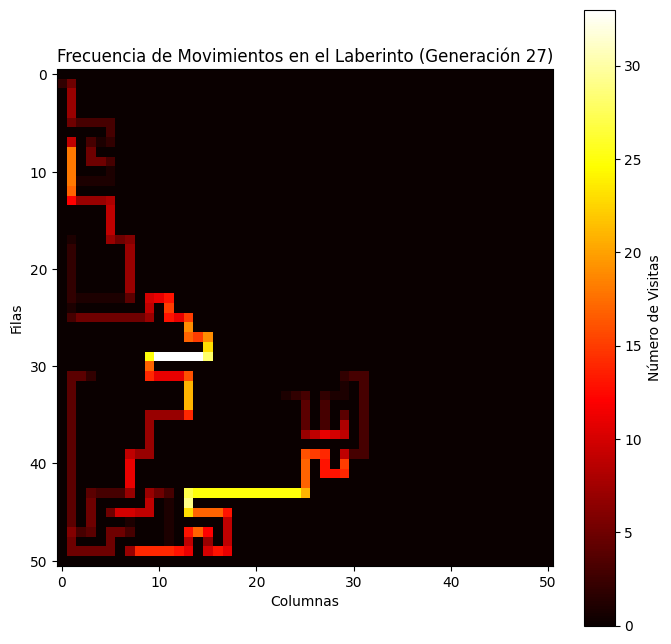

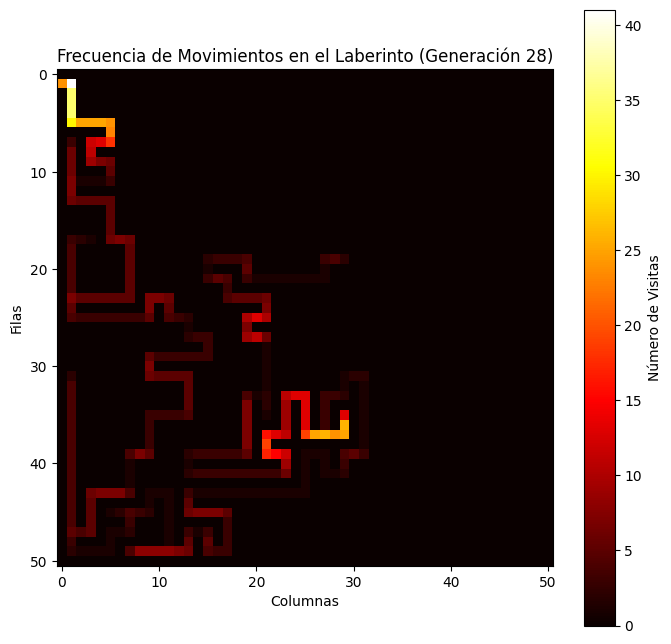

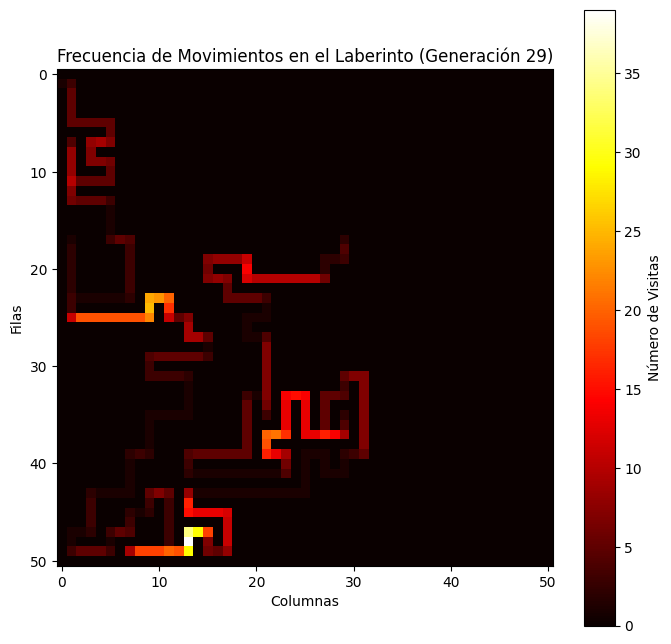

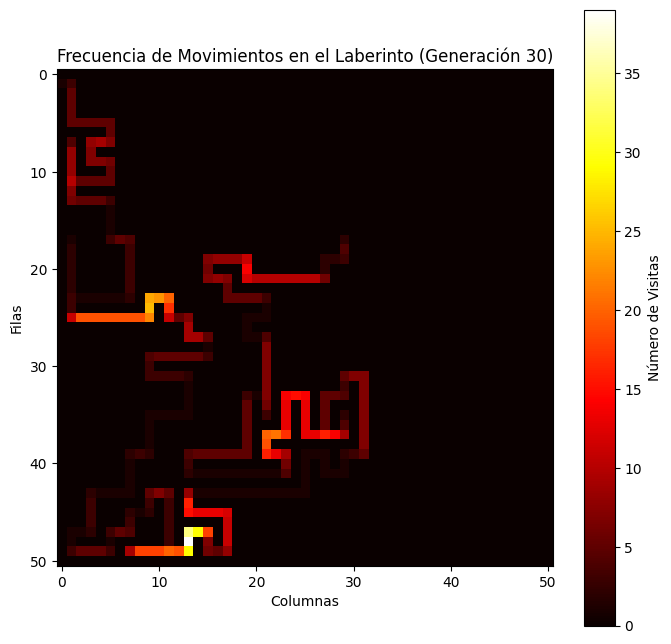

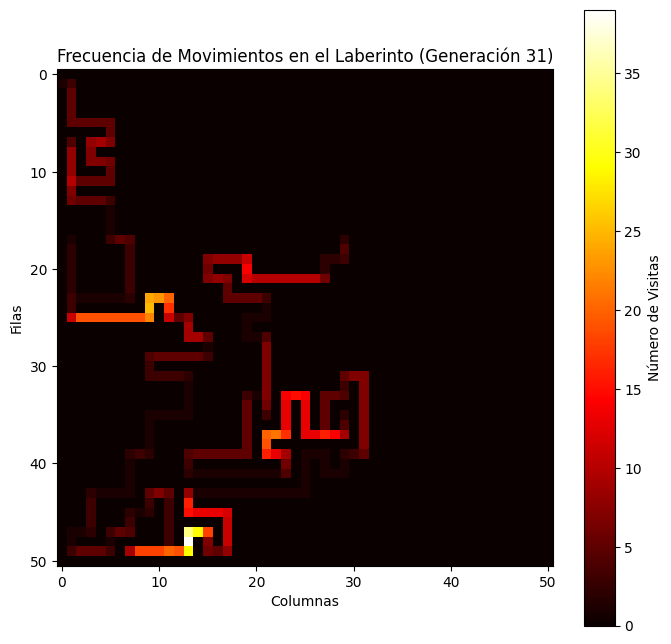

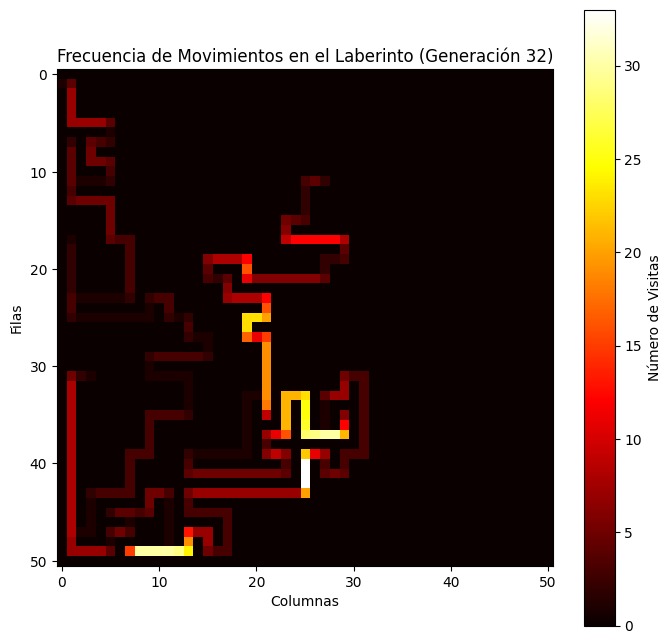

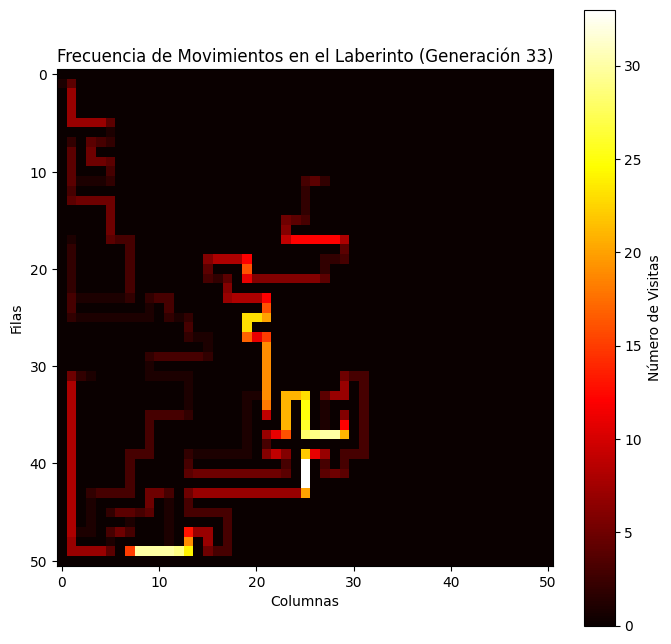

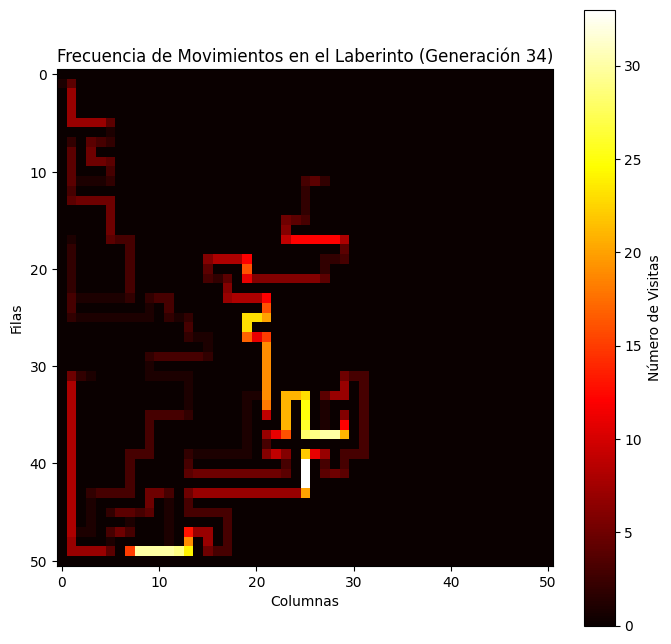

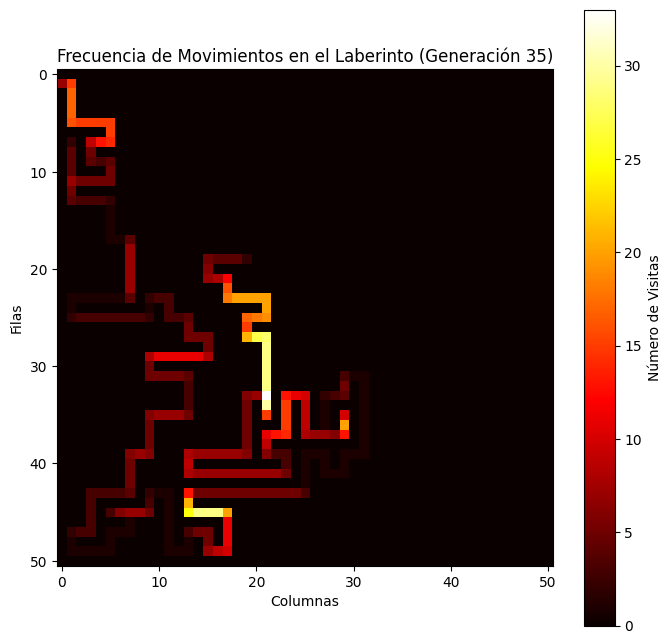

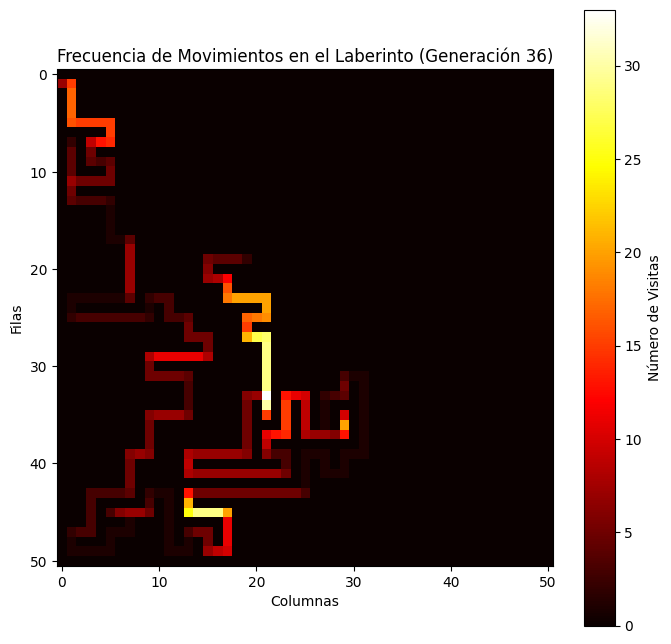

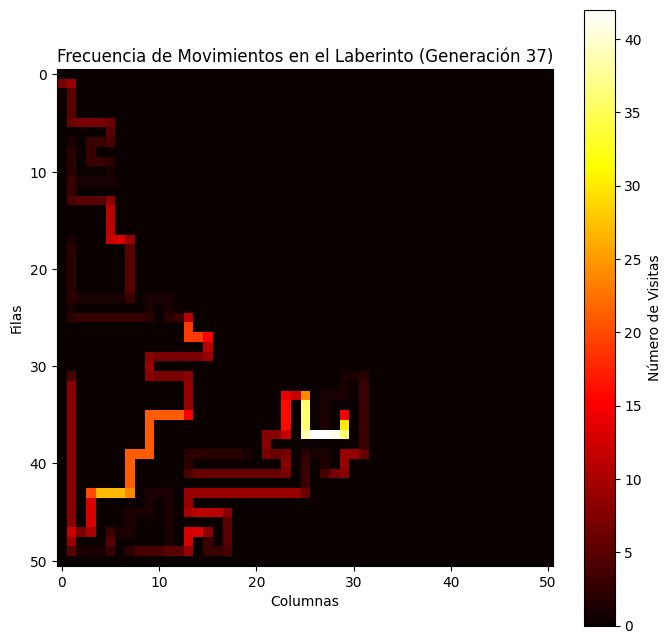

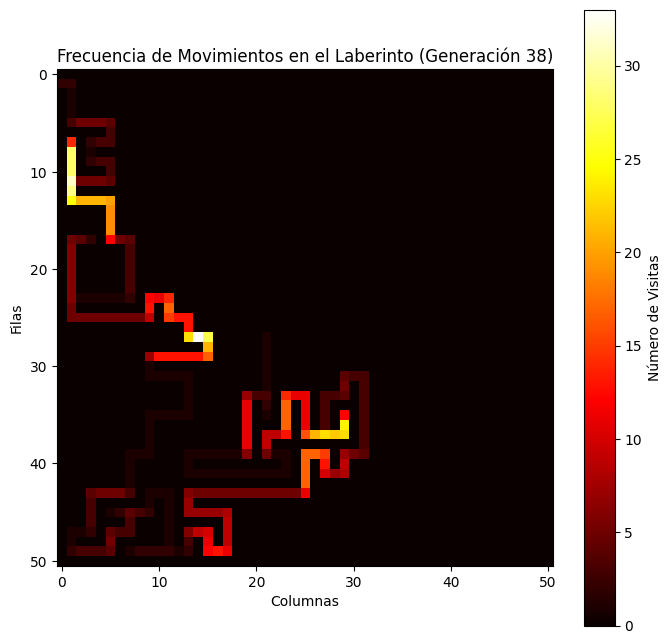

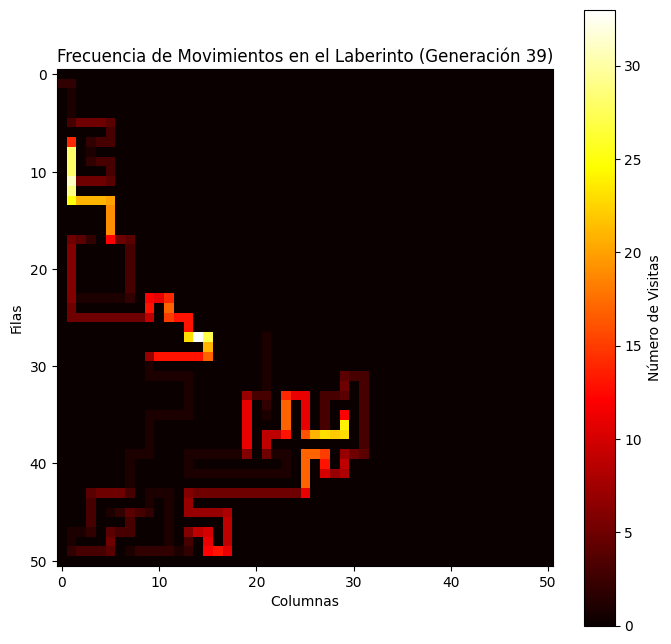

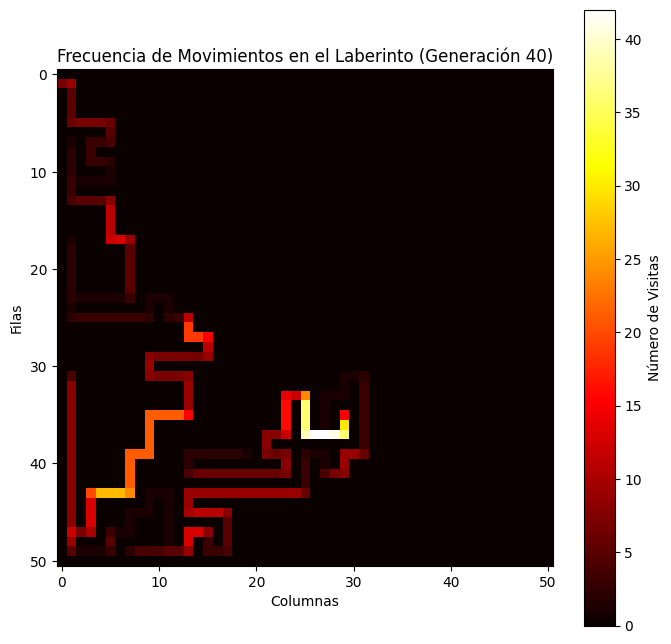

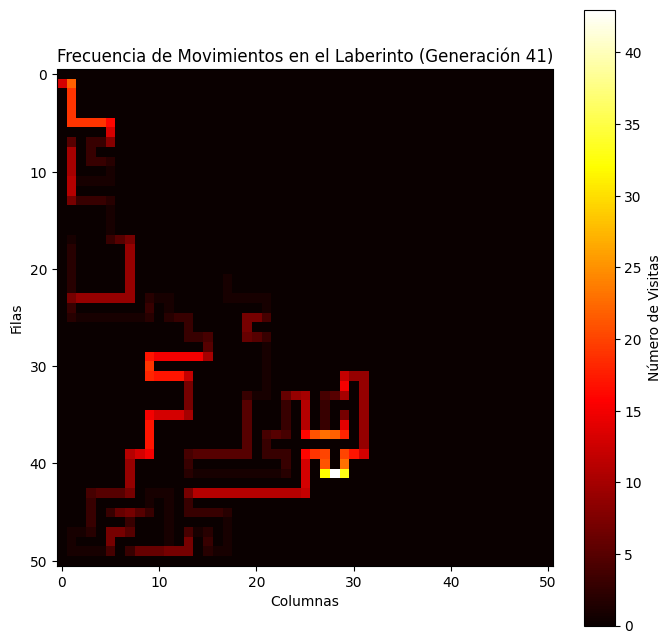

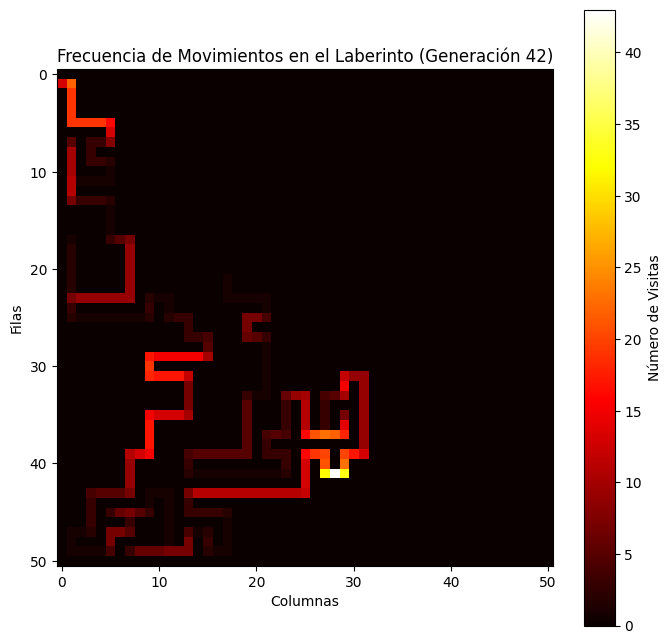

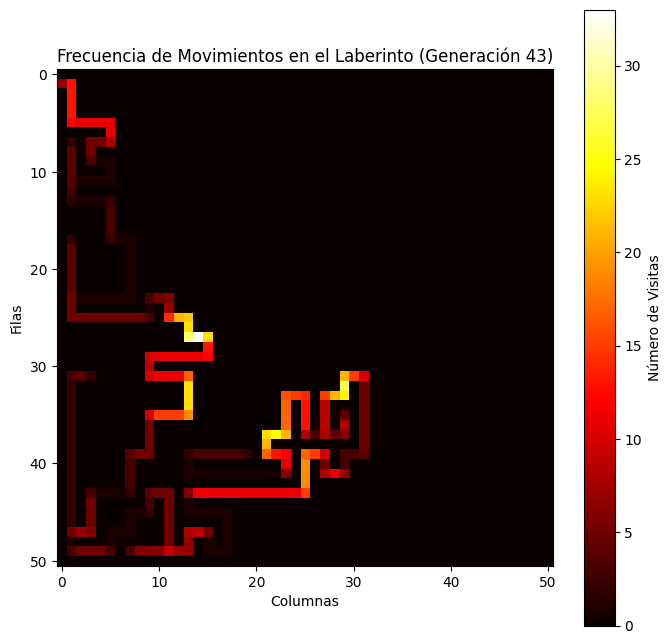

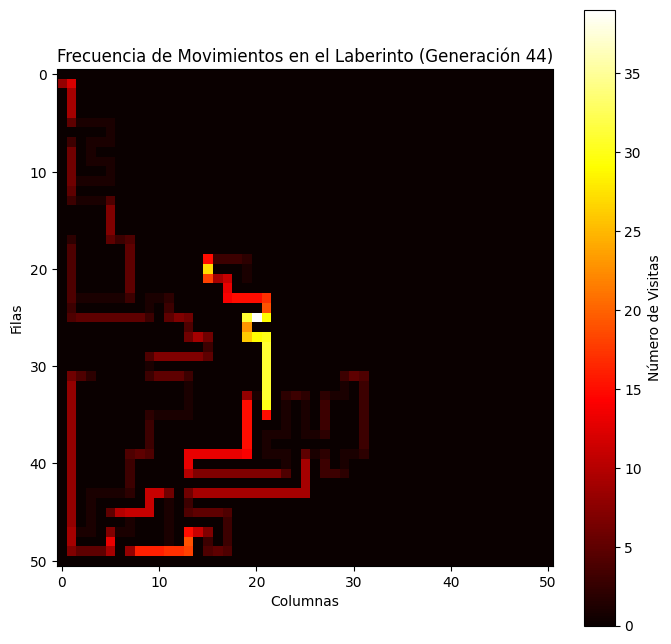

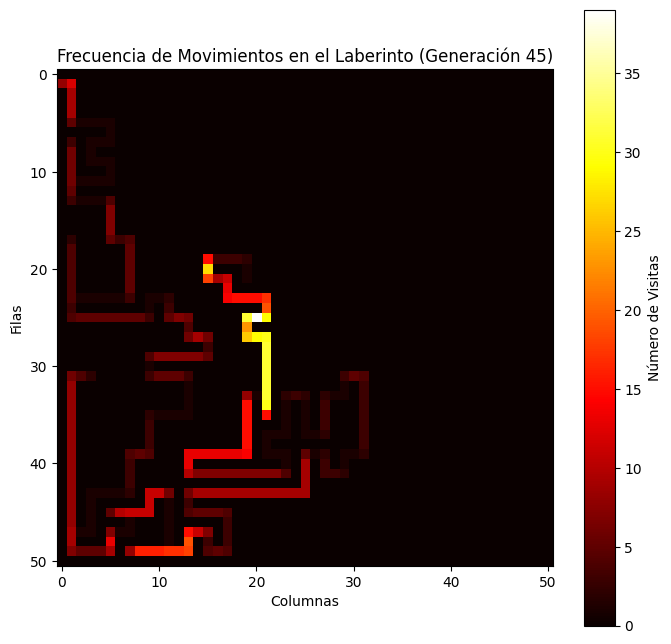

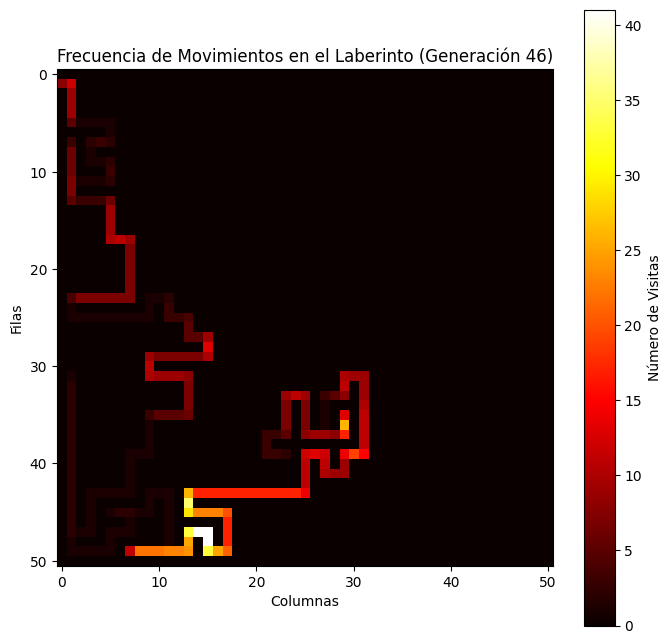

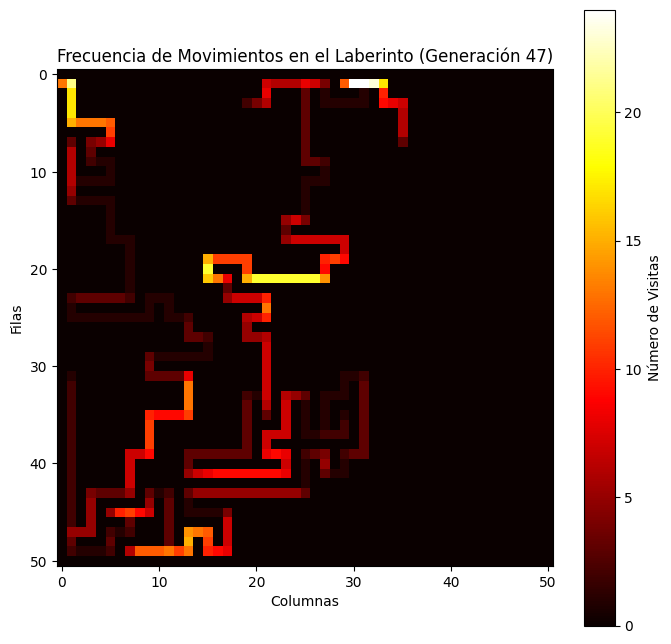

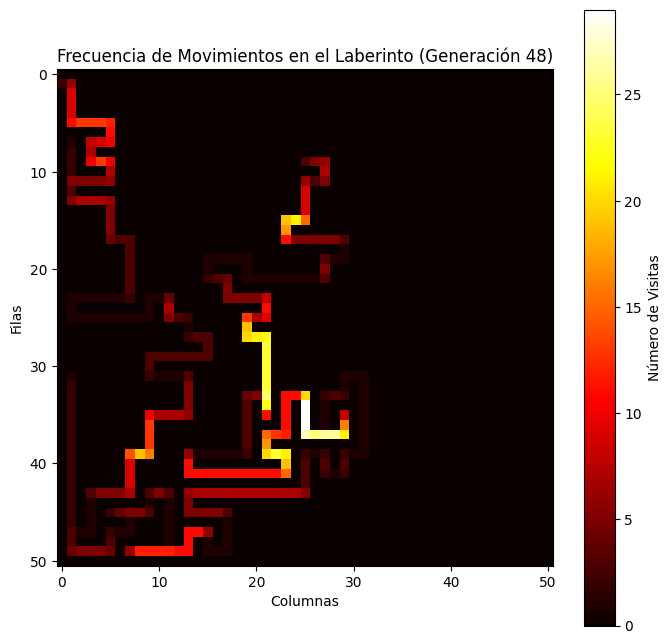

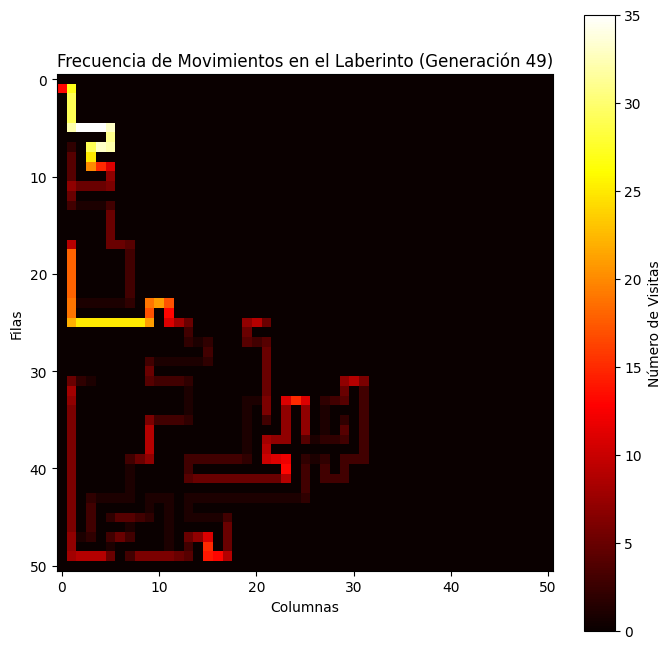

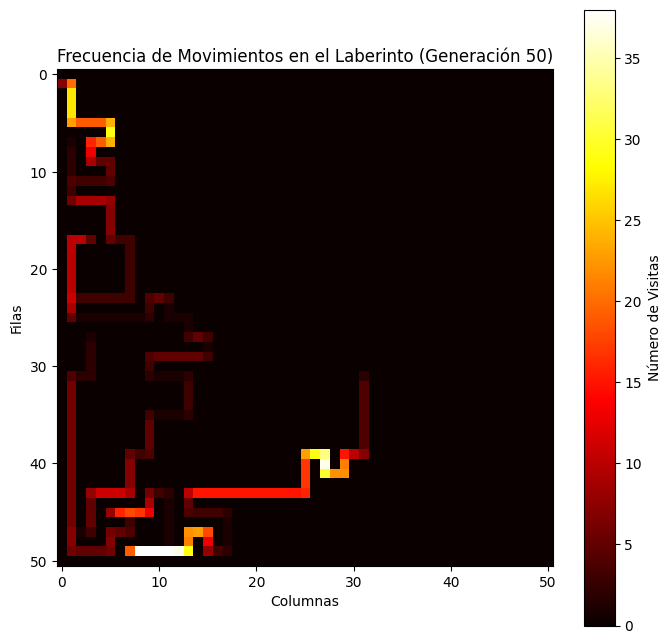

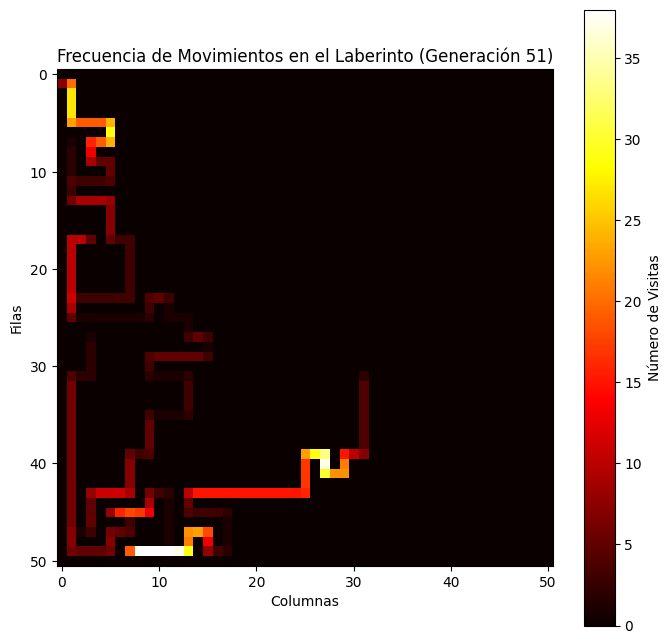

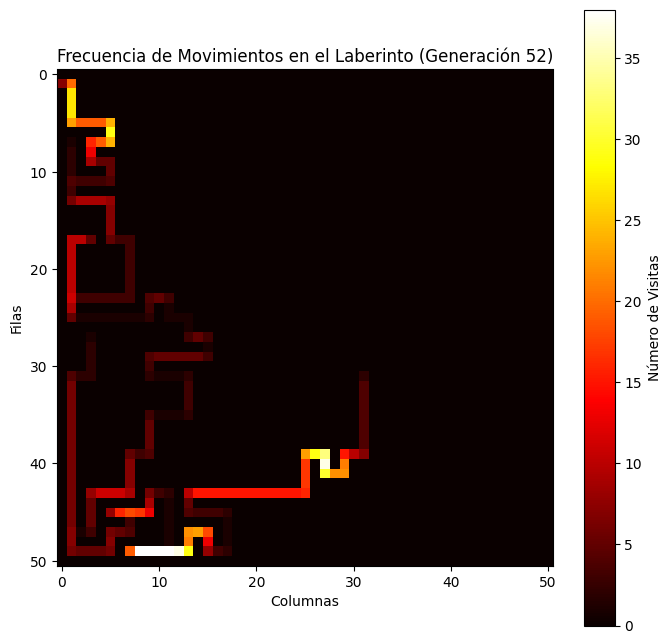

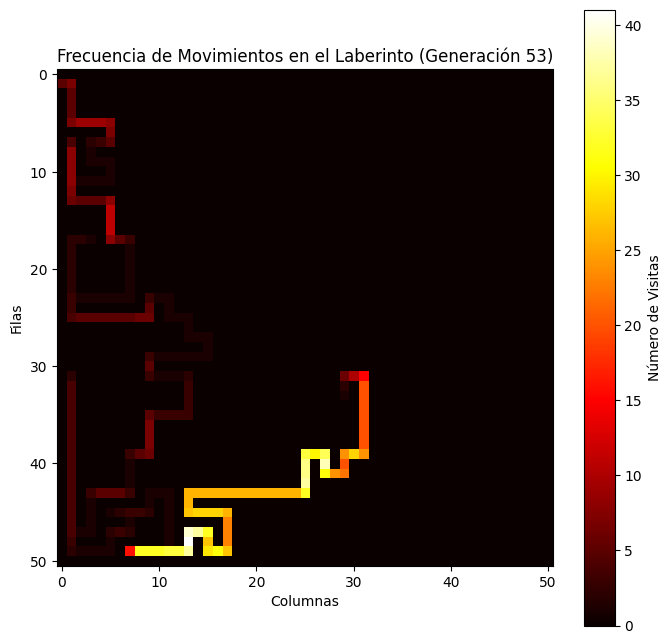

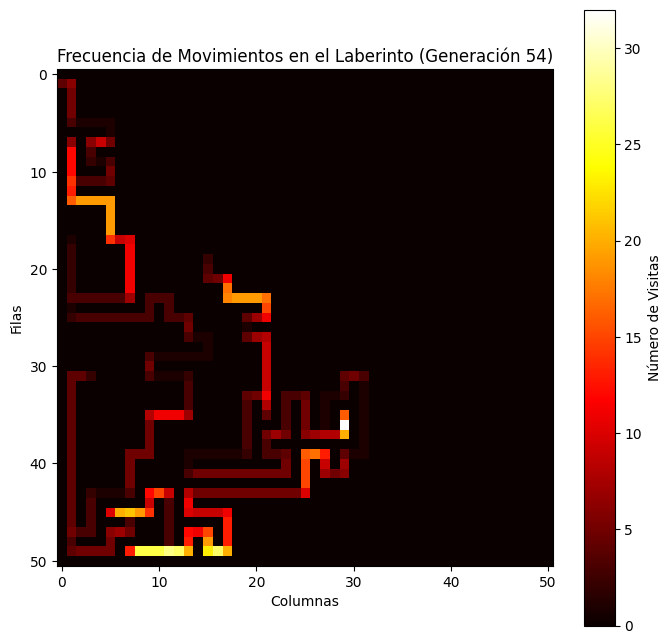

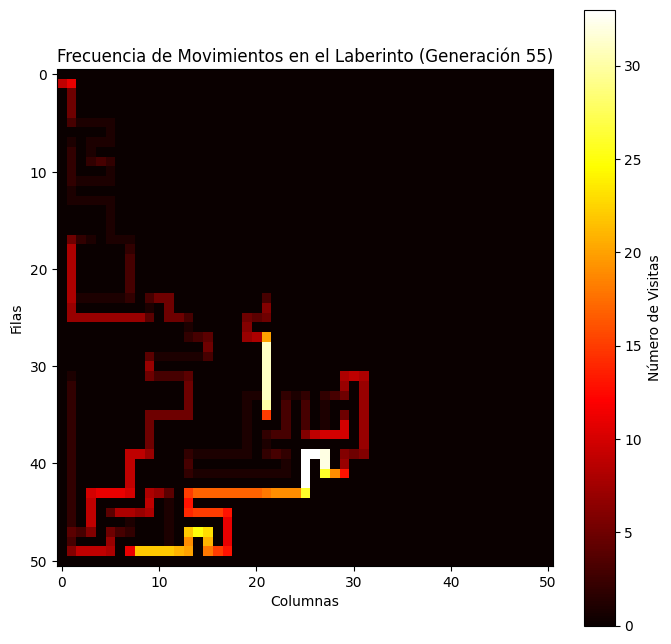

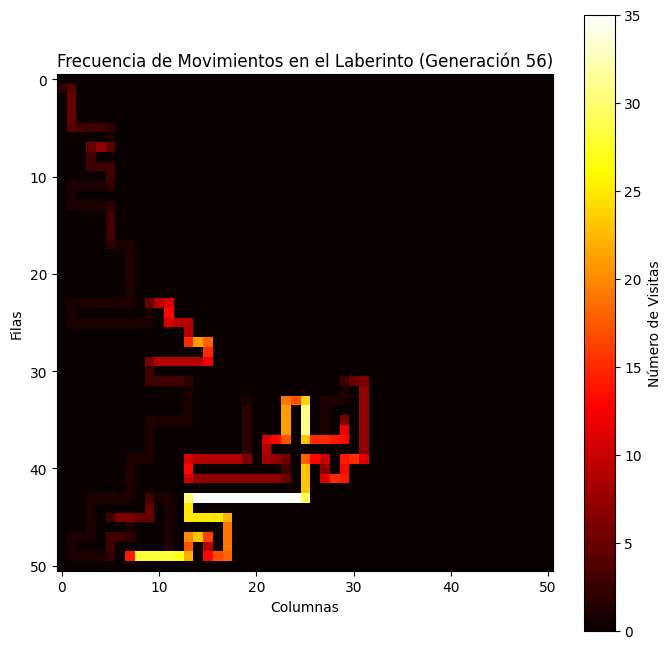

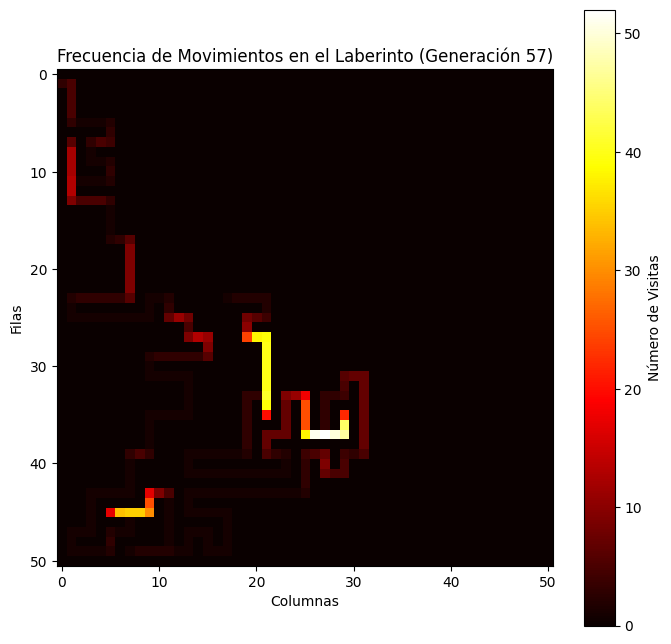

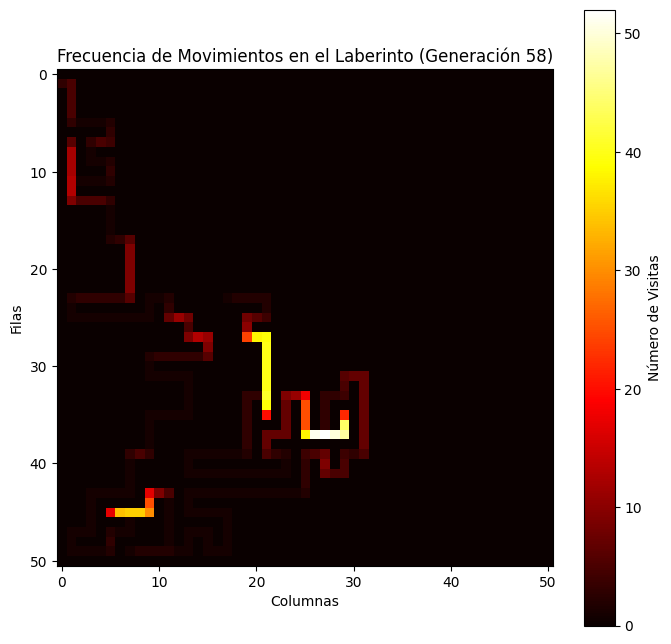

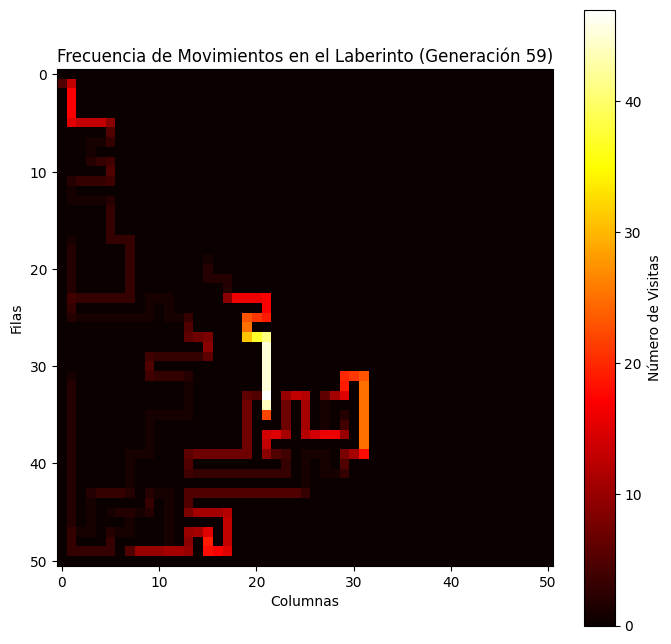

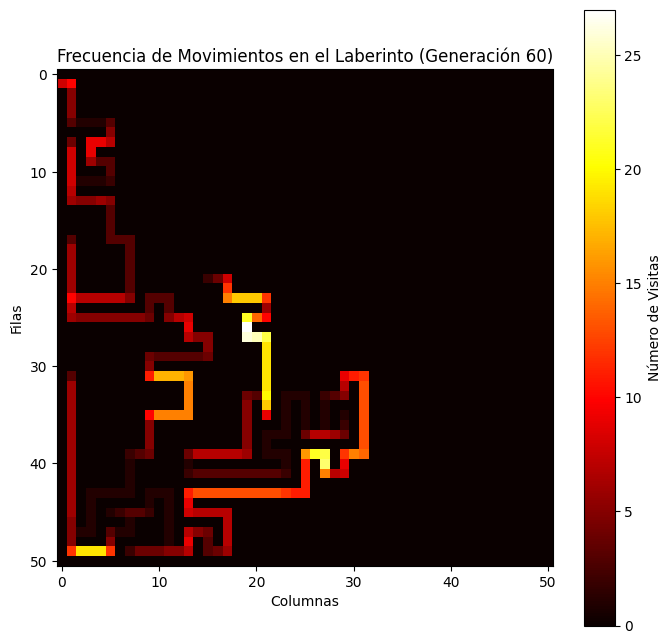

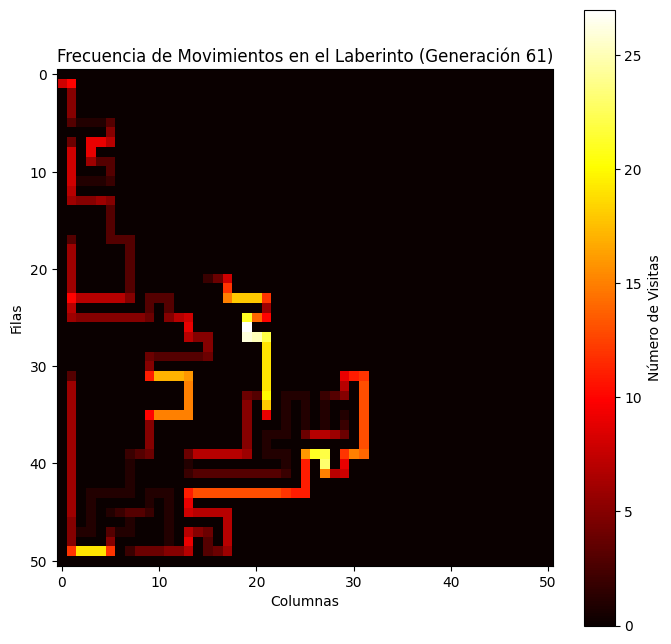

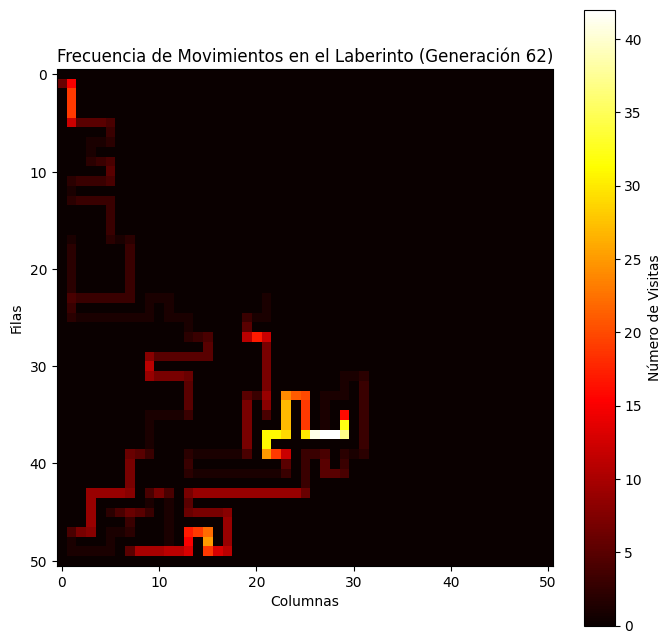

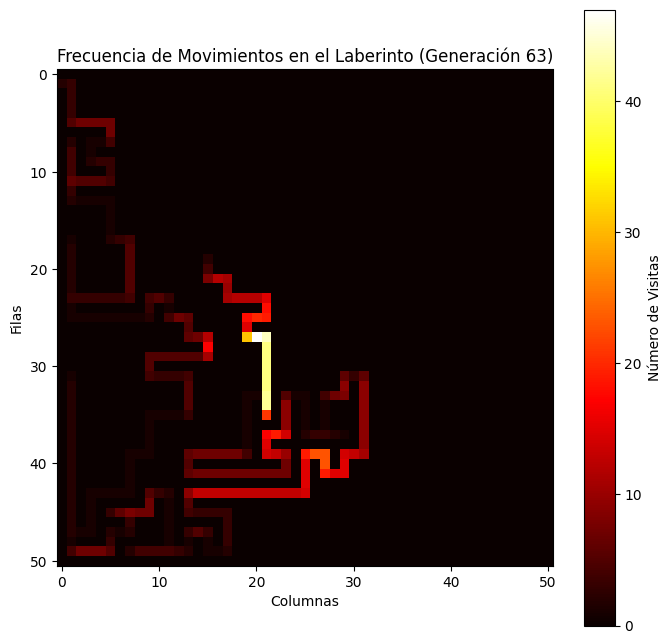

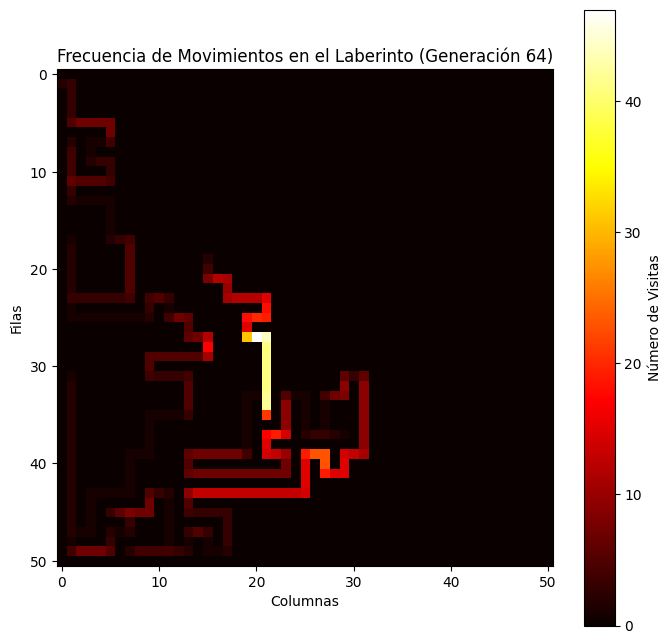

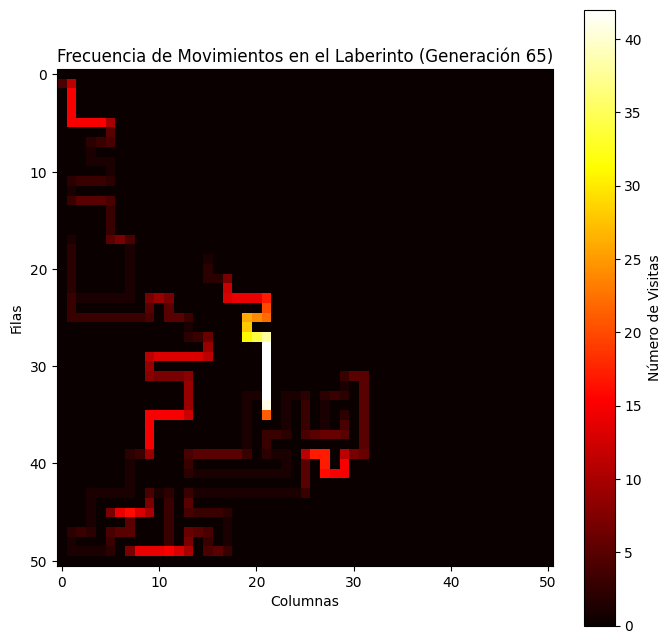

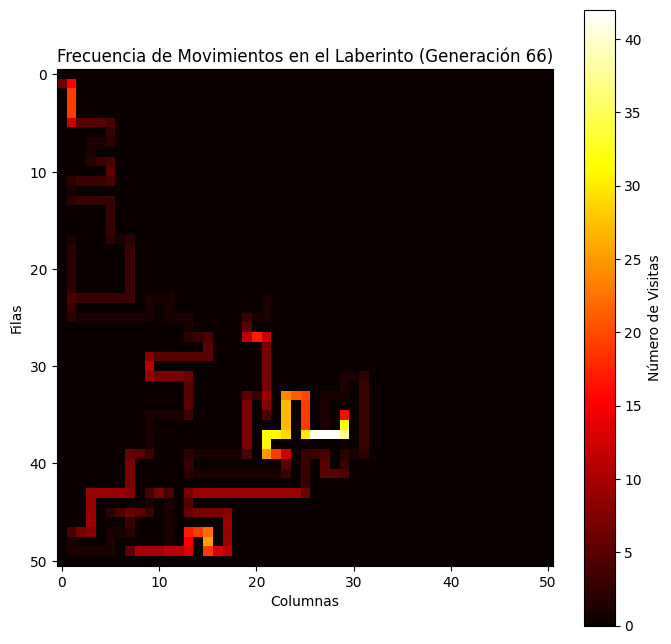

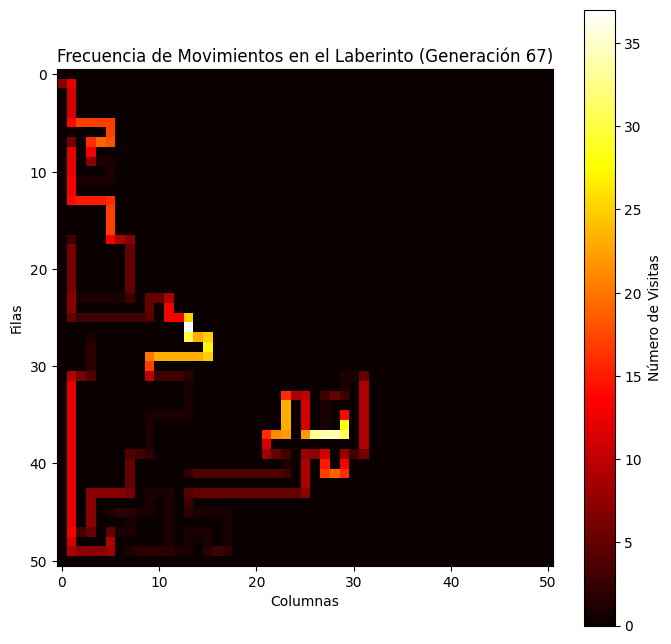

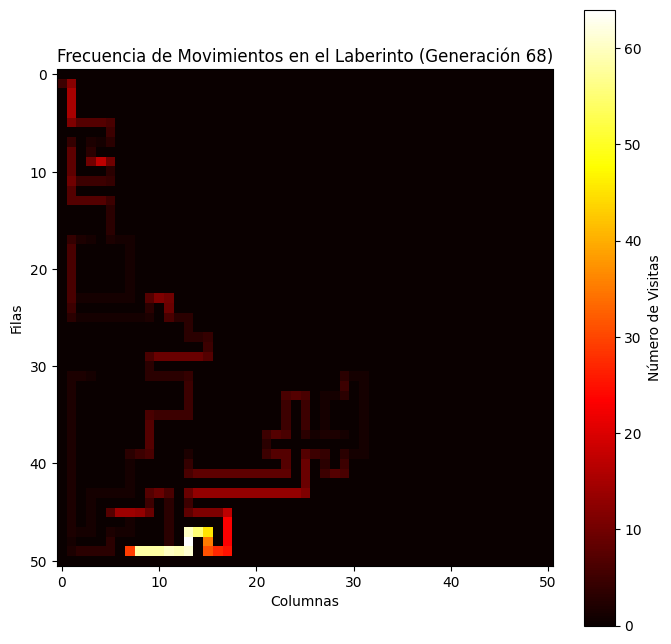

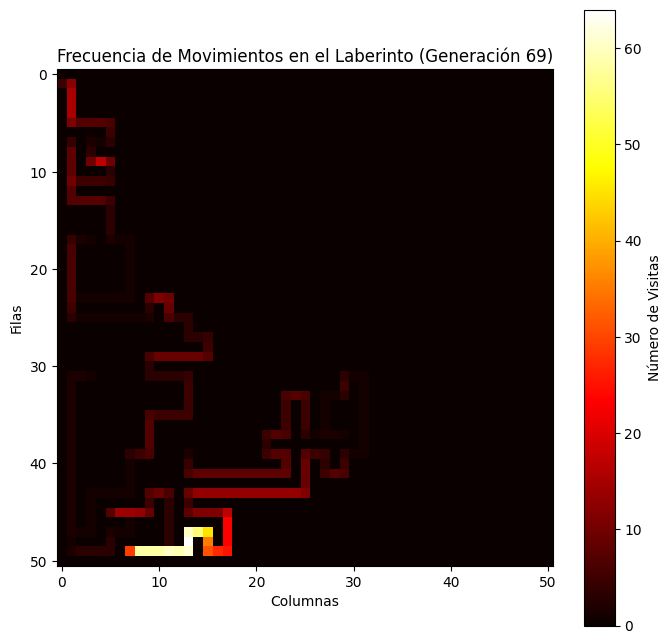

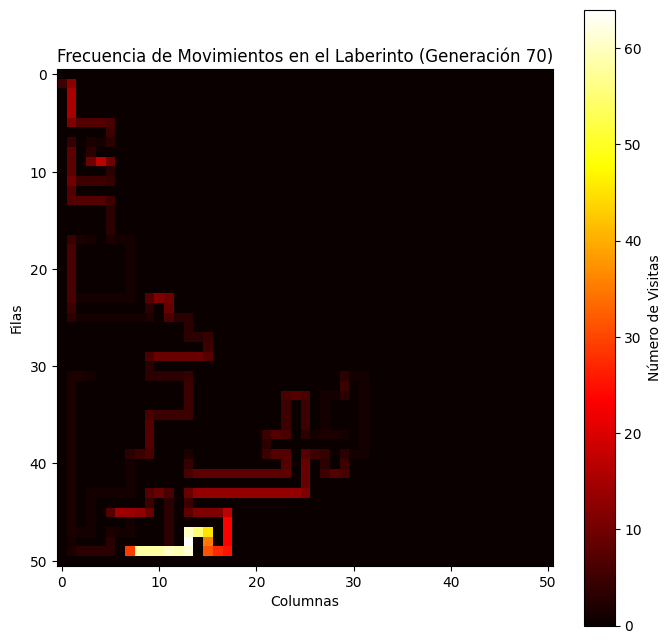

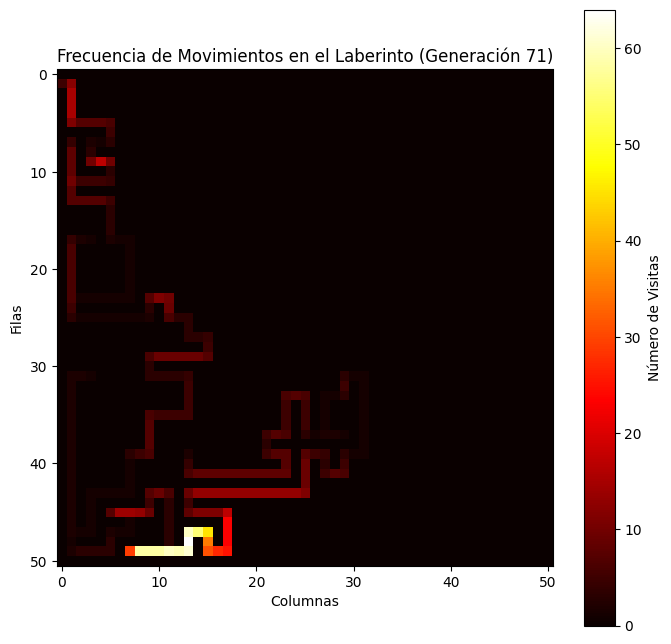

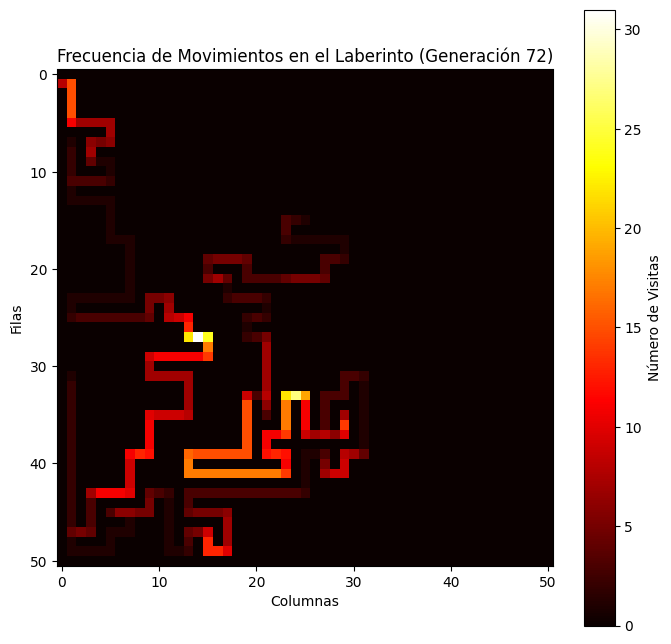

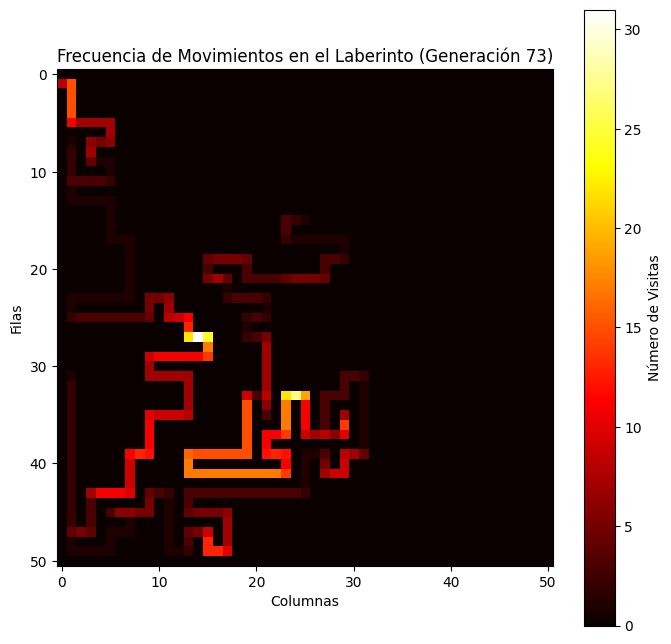

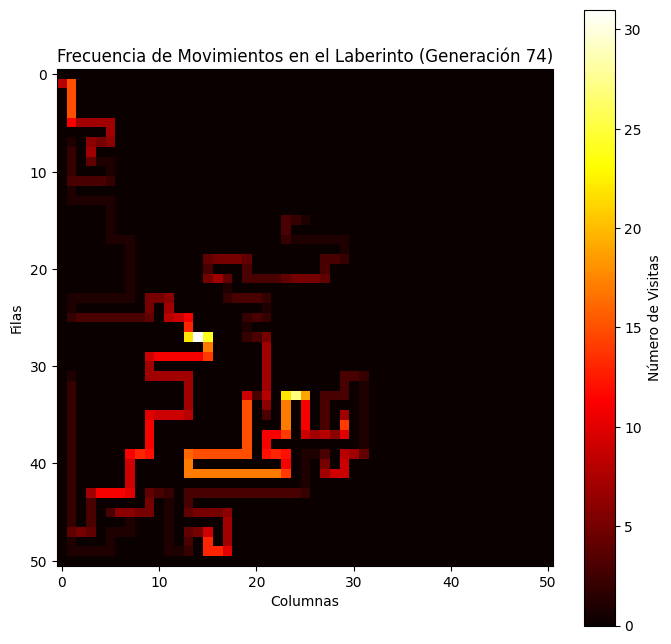

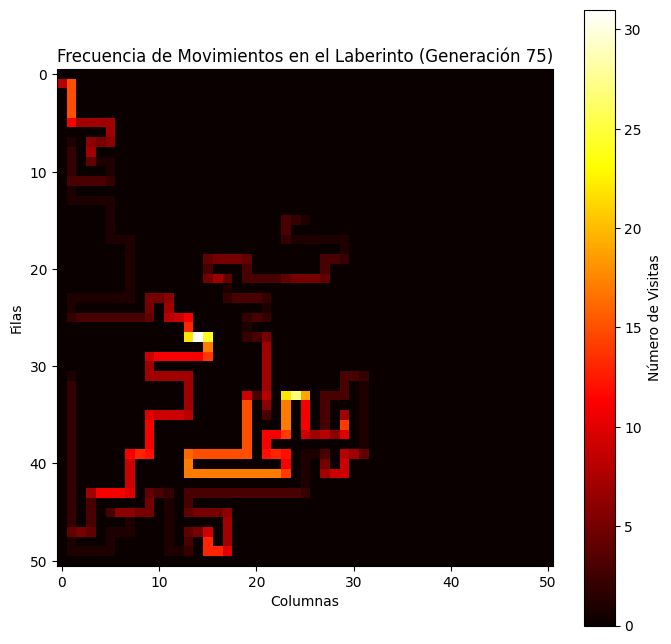

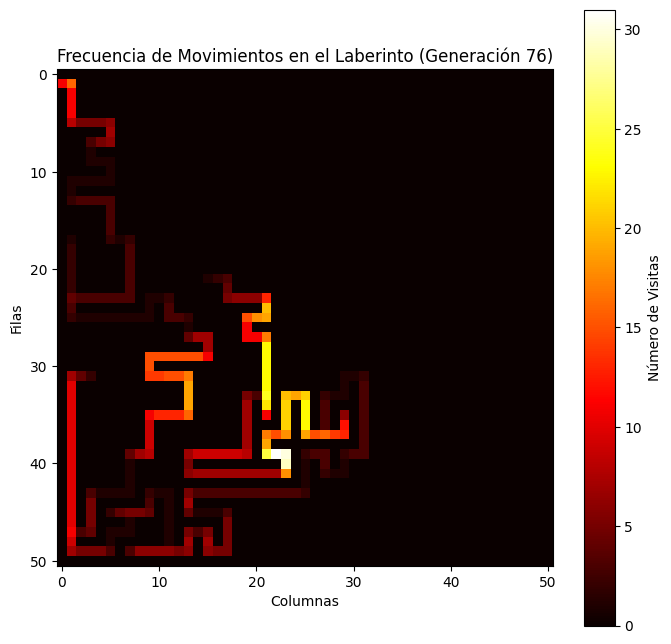

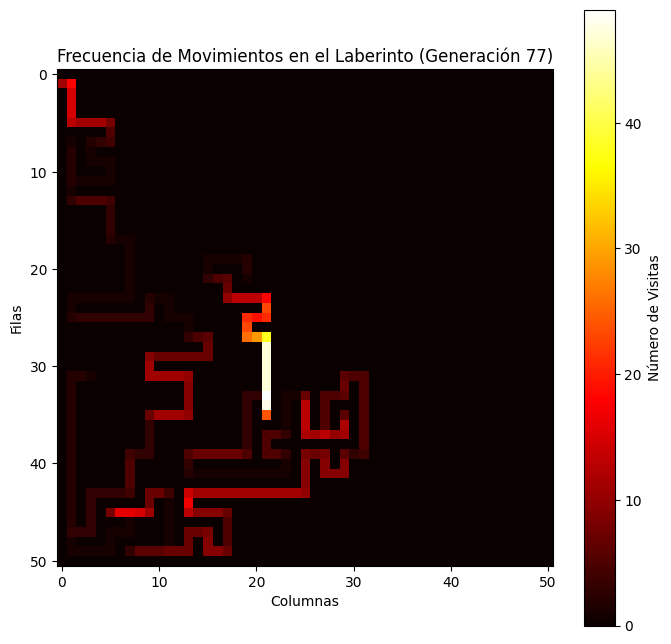

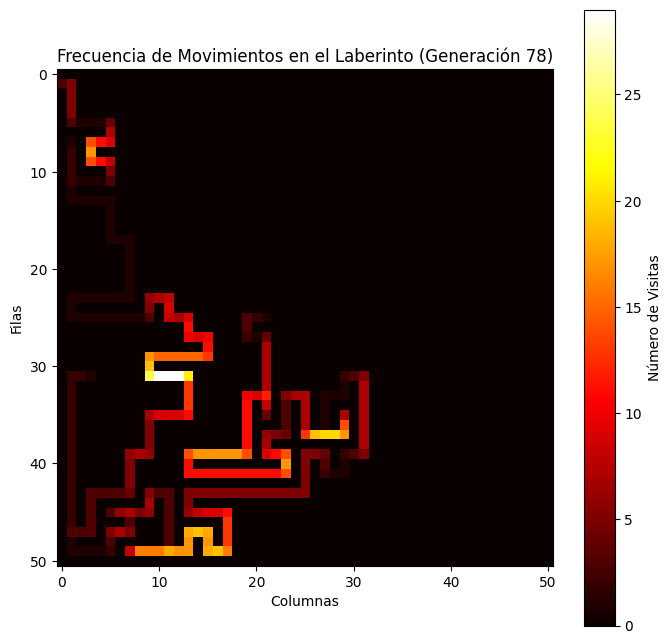

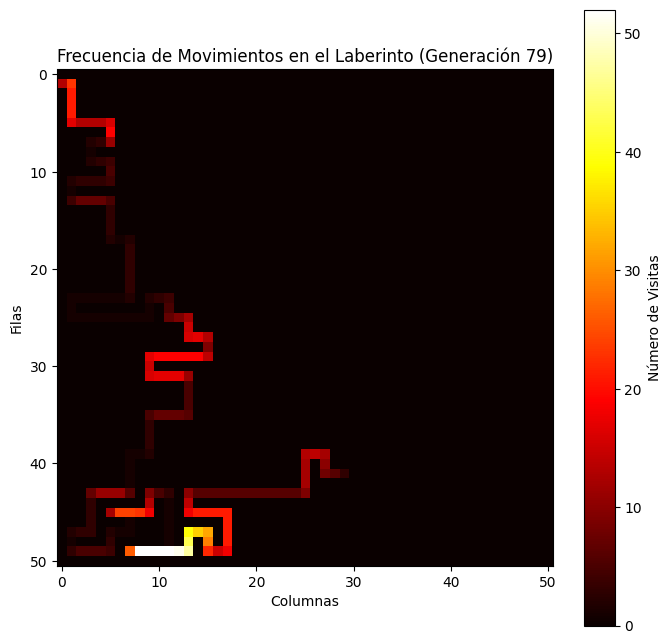

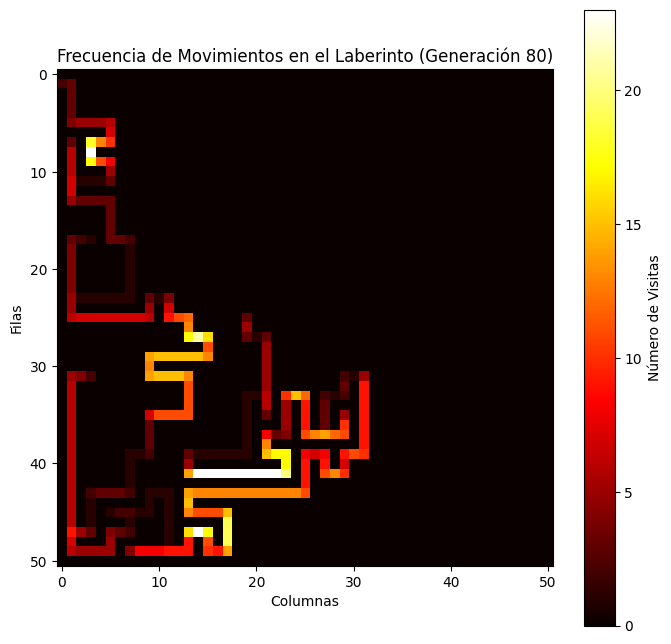

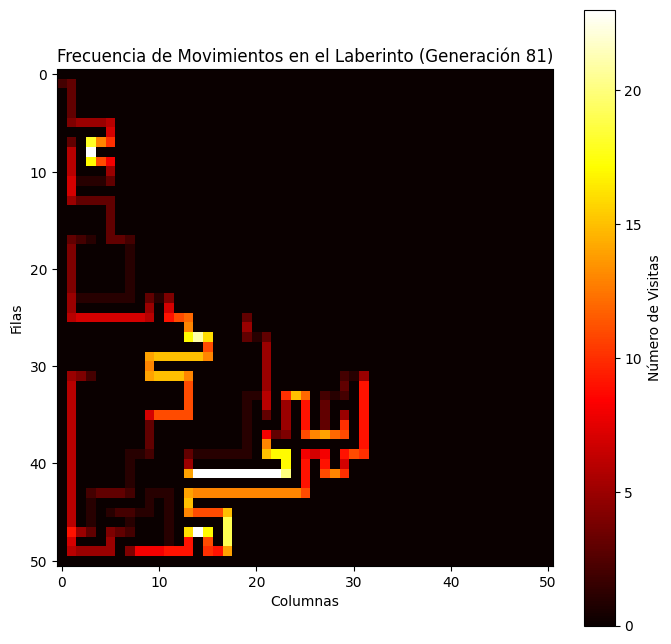

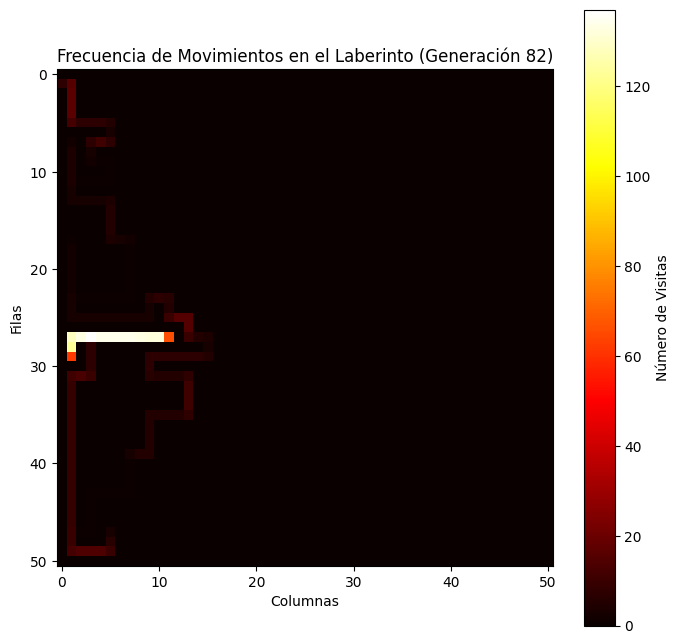

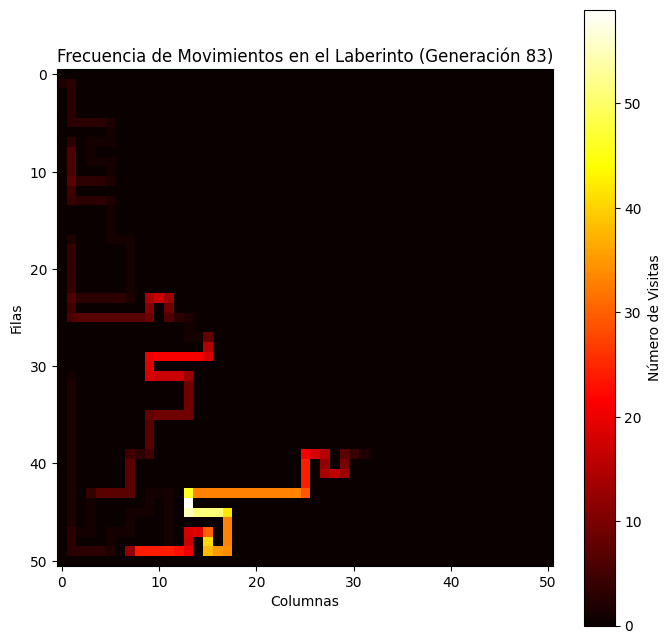

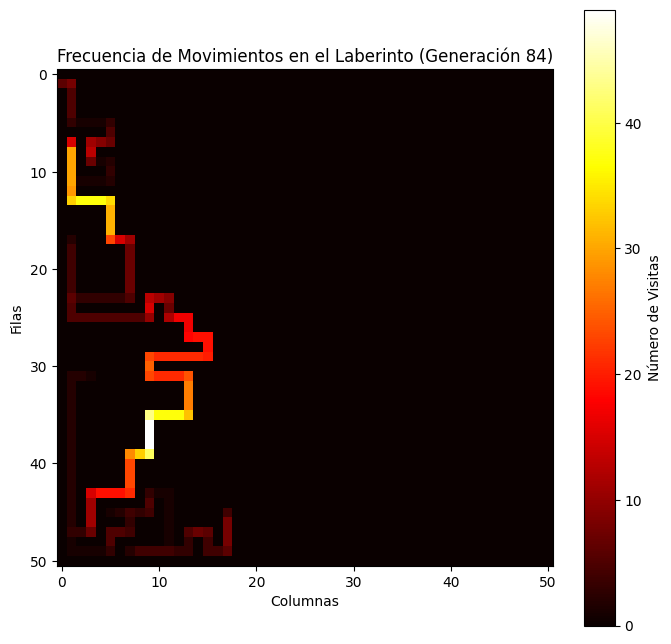

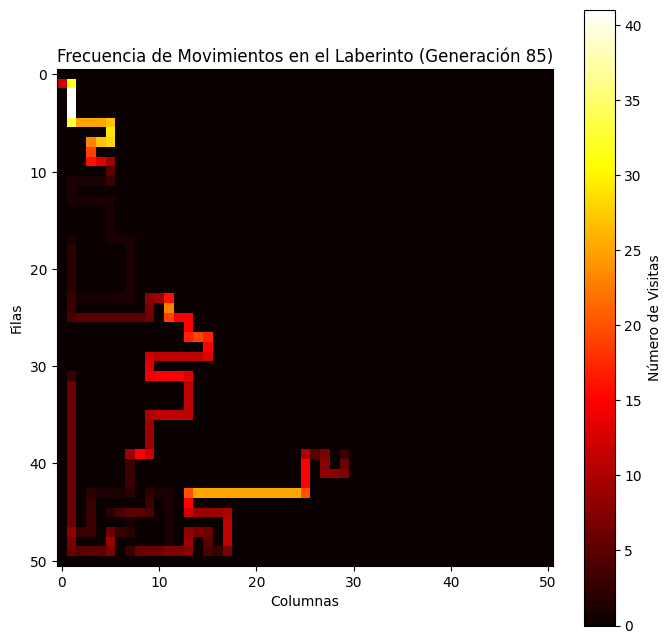

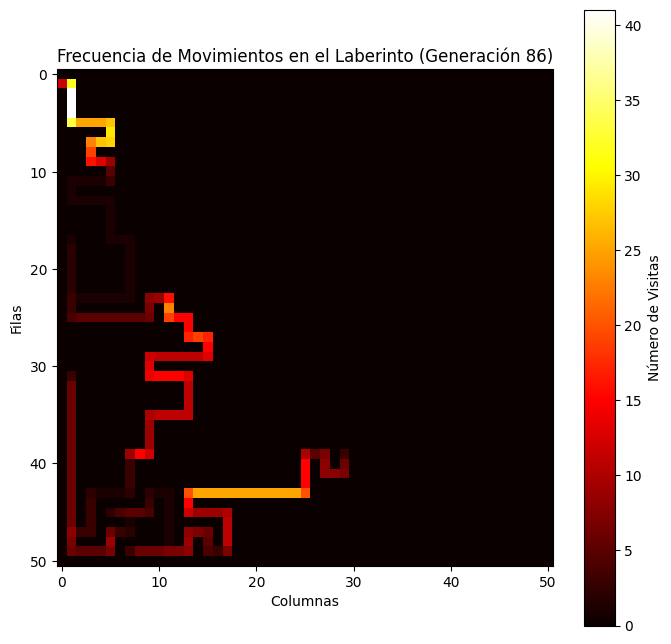

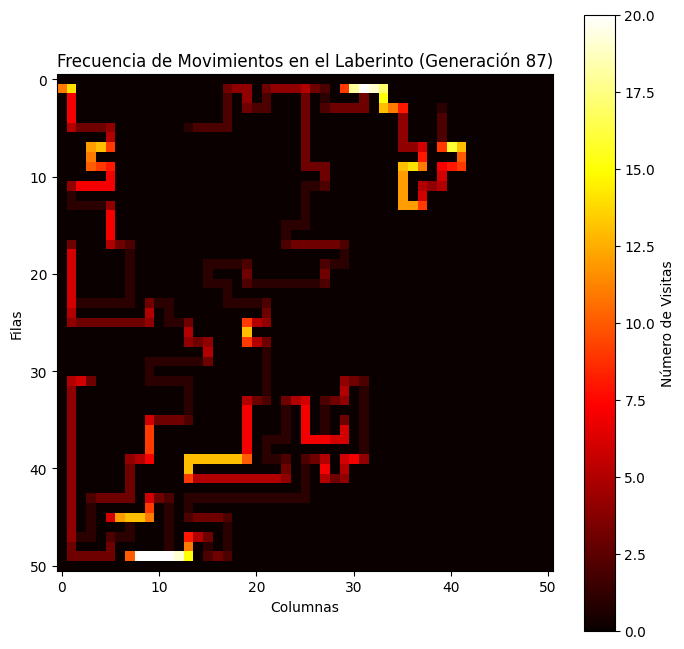

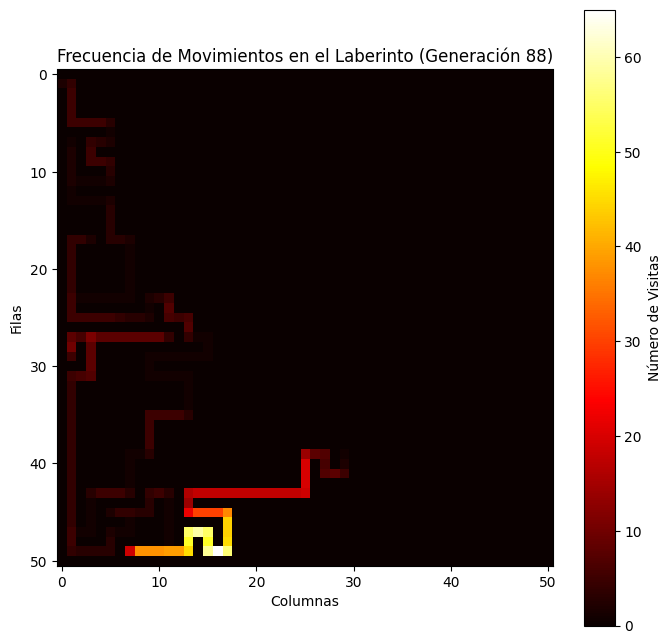

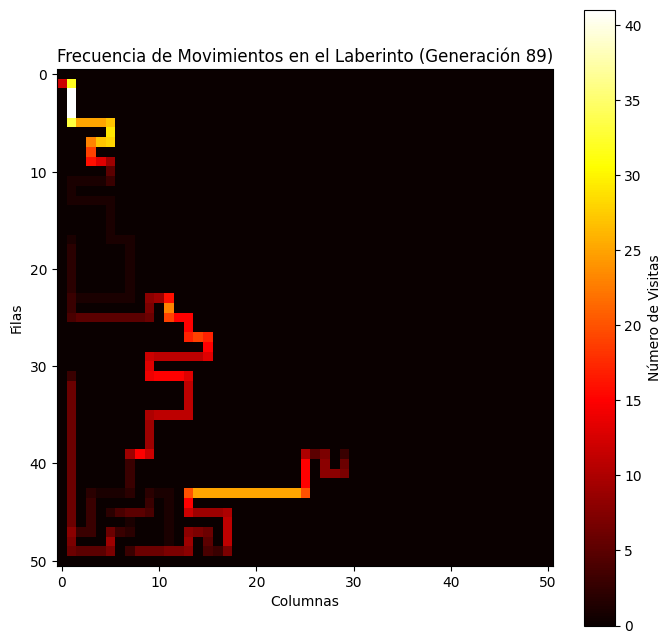

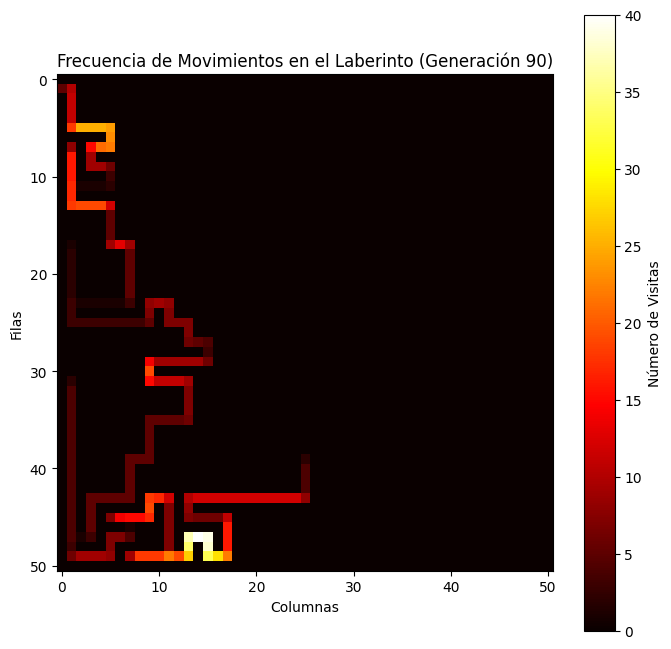

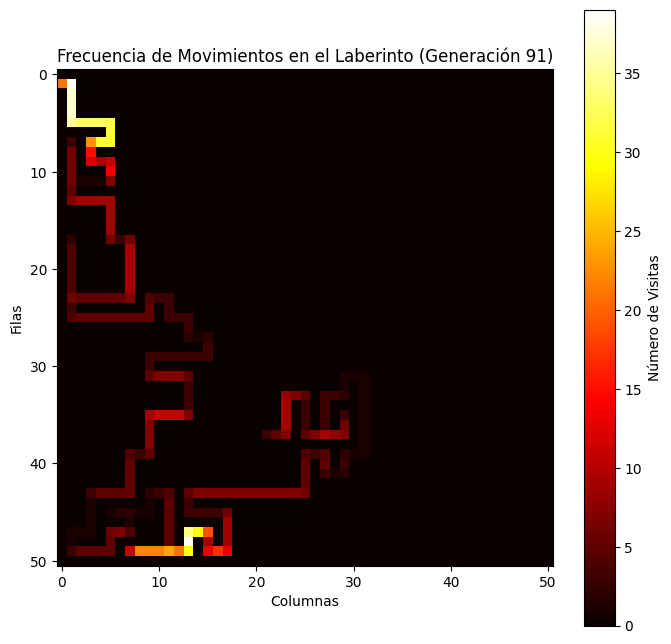

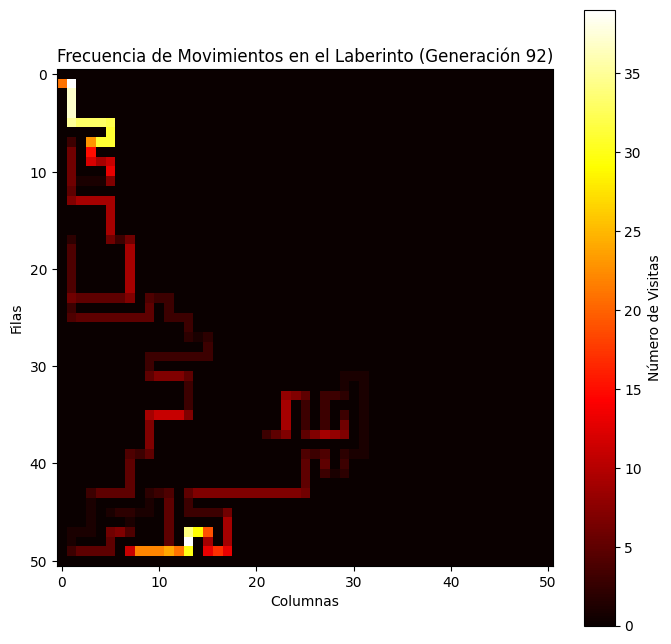

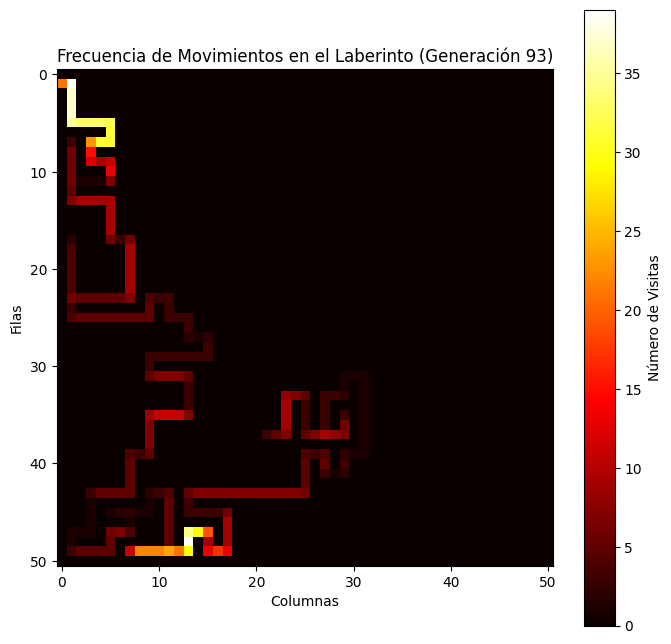

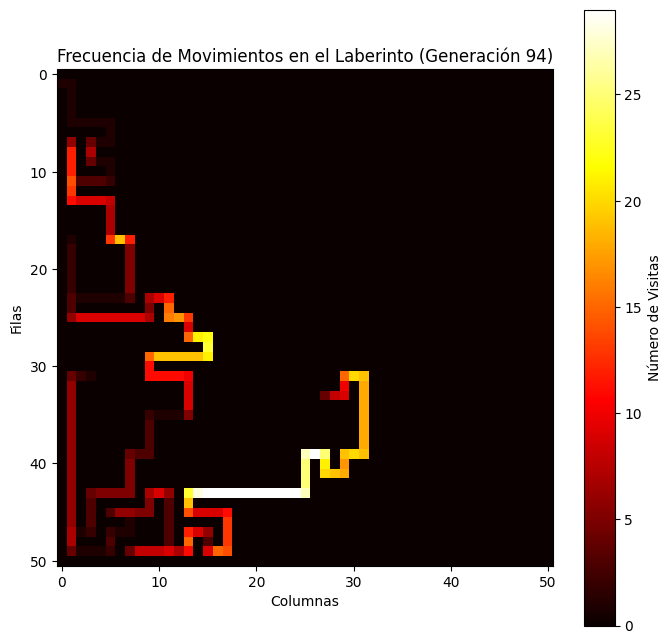

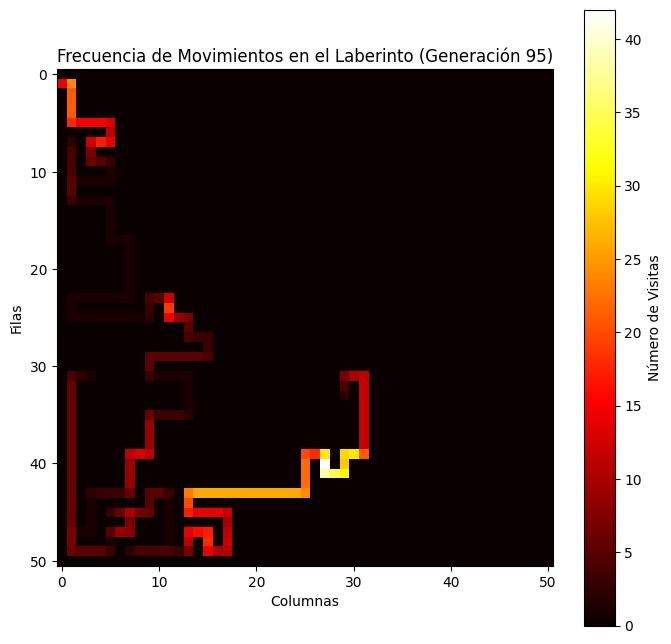

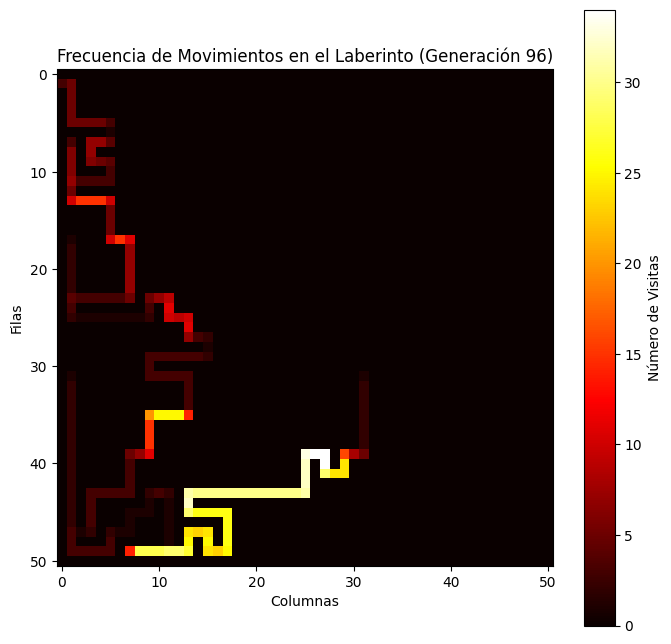

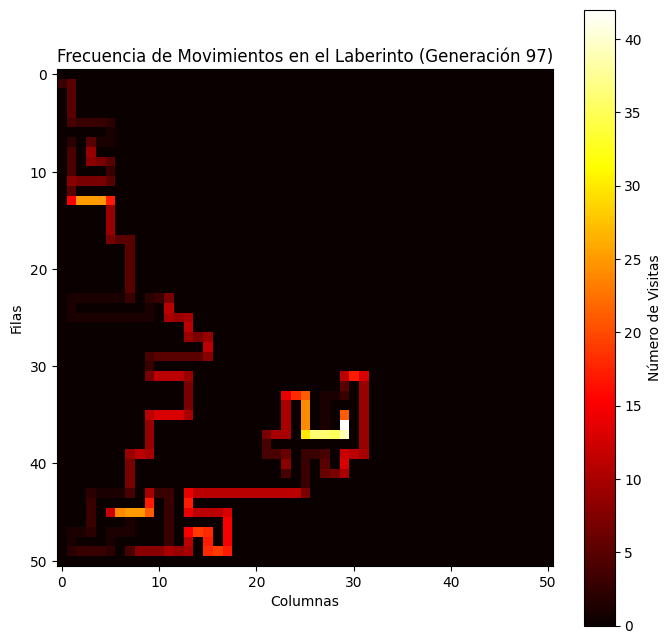

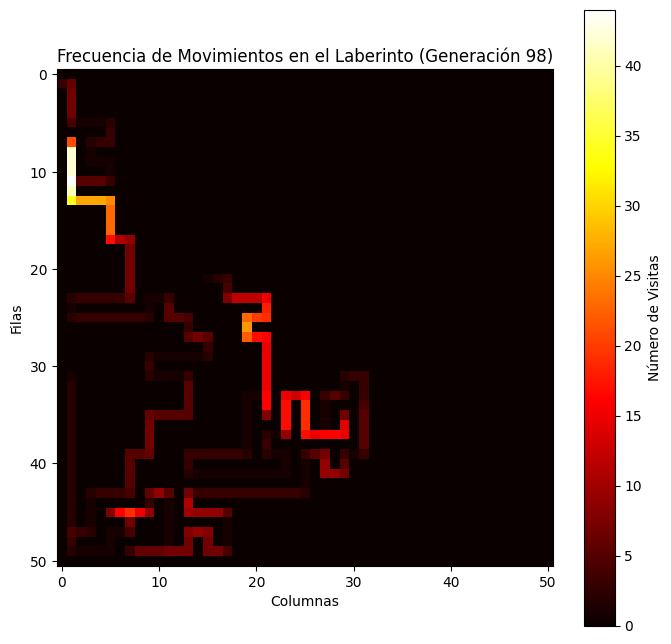

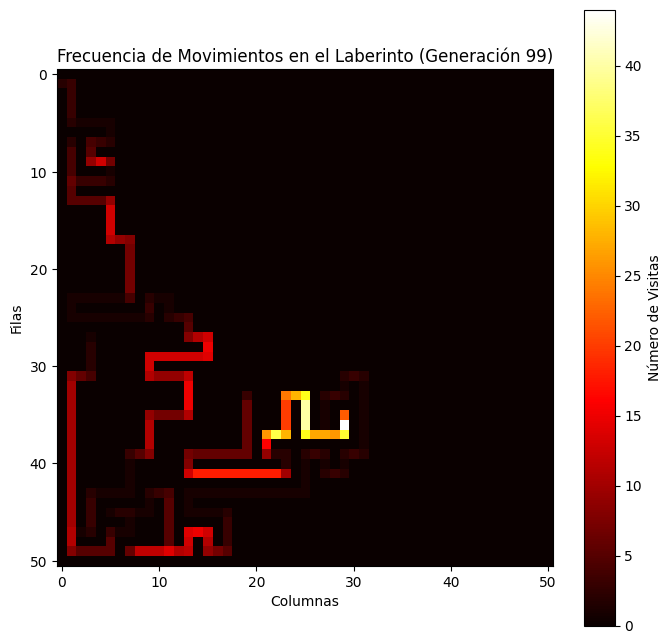

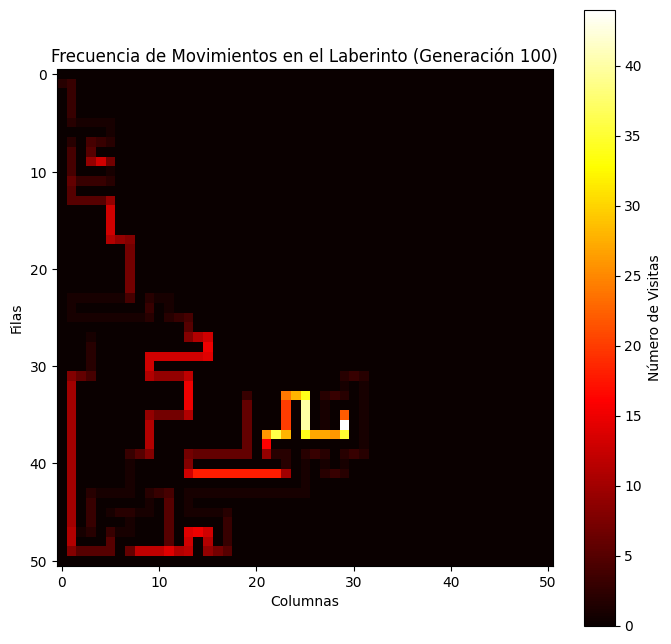

In [49]:
solver = GeneticMazeSolver()

population = solver.generate_population(50, dim*dim * 2)
start = (1, 0)
end = (dim * 2 - 1, dim * 2)
solution, fitness = solver.evolve(population, maze, start, end)